# DQAN: DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[ 0.04927189 -0.16509547  0.04587628  0.34025463] 0 1.0 False {}
state, action, reward, done, info
[0.04596999 0.02934473 0.05268137 0.06238409] 1 1.0 False {}
state, action, reward, done, info
[ 0.04655688  0.22367332  0.05392905 -0.21322324] 1 1.0 False {}
state, action, reward, done, info
[0.05103035 0.02782348 0.04966459 0.09597189] 0 1.0 False {}
state, action, reward, done, info
[ 0.05158682  0.22219973  0.05158402 -0.18063759] 1 1.0 False {}
state, action, reward, done, info
[ 0.05603081  0.41654704  0.04797127 -0.45661181] 1 1.0 False {}
state, action, reward, done, info
[ 0.06436175  0.61095911  0.03883904 -0.73379629] 1 1.0 False {}
state, action, reward, done, info
[ 0.07658093  0.80552354  0.02416311 -1.01400704] 1 1.0 False {}
state, action, reward, done, info
[ 0.0926914   1.00031501  0.00388297 -1.29900569] 1 1.0 False {}
state, action, reward, done, info
[ 0.1126977   1.19538745 -0.02209714 -1.59047056] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1953874532853495 -1.5904705557941337


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [6]:
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        return logits

In [7]:
def discriminator(actions, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [8]:
def model_loss(states, actions, action_size, hidden_size, state_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, 
                               state_size=state_size)
    actions_fake = tf.nn.softmax(actions_logits)
    d_logits_fake = discriminator(actions=actions_fake, hidden_size=hidden_size, action_size=action_size)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    d_logits_real = discriminator(actions=actions_real, hidden_size=hidden_size, action_size=action_size, 
                                  reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake

In [9]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [10]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, states=self.states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
train_episodes = 10000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [13]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [14]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [15]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            feed_dict={model.states: next_states}
            next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation
            targetQs = next_rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

Episode: 0 Total reward: 5.0 Training d_loss: 1.3833 Training g_loss: 0.6908 Training q_loss: 0.4484 Explore P: 0.9995
Episode: 1 Total reward: 11.0 Training d_loss: 1.3210 Training g_loss: 0.7272 Training q_loss: 0.5769 Explore P: 0.9984
Episode: 2 Total reward: 18.0 Training d_loss: 1.2916 Training g_loss: 0.7359 Training q_loss: 0.7180 Explore P: 0.9966
Episode: 3 Total reward: 16.0 Training d_loss: 1.3150 Training g_loss: 0.7188 Training q_loss: 11.8993 Explore P: 0.9951
Episode: 4 Total reward: 17.0 Training d_loss: 1.3380 Training g_loss: 0.7390 Training q_loss: 21.0891 Explore P: 0.9934
Episode: 5 Total reward: 13.0 Training d_loss: 1.3244 Training g_loss: 0.7499 Training q_loss: 9.3055 Explore P: 0.9921
Episode: 6 Total reward: 36.0 Training d_loss: 1.4197 Training g_loss: 0.7101 Training q_loss: 20.7287 Explore P: 0.9886
Episode: 7 Total reward: 30.0 Training d_loss: 1.3510 Training g_loss: 0.7109 Training q_loss: 131.2267 Explore P: 0.9857
Episode: 8 Total reward: 19.0 Traini

Episode: 68 Total reward: 20.0 Training d_loss: 1.3751 Training g_loss: 0.7162 Training q_loss: 340.5836 Explore P: 0.8818
Episode: 69 Total reward: 12.0 Training d_loss: 1.3858 Training g_loss: 0.6911 Training q_loss: 144.7510 Explore P: 0.8808
Episode: 70 Total reward: 13.0 Training d_loss: 1.2977 Training g_loss: 0.8421 Training q_loss: 745.6630 Explore P: 0.8797
Episode: 71 Total reward: 42.0 Training d_loss: 1.3601 Training g_loss: 0.6778 Training q_loss: 111.8519 Explore P: 0.8760
Episode: 72 Total reward: 11.0 Training d_loss: 1.3719 Training g_loss: 0.7571 Training q_loss: 1354.4993 Explore P: 0.8751
Episode: 73 Total reward: 11.0 Training d_loss: 1.3401 Training g_loss: 0.6762 Training q_loss: 329.9167 Explore P: 0.8741
Episode: 74 Total reward: 19.0 Training d_loss: 1.3680 Training g_loss: 0.7083 Training q_loss: 38.9823 Explore P: 0.8725
Episode: 75 Total reward: 10.0 Training d_loss: 1.3751 Training g_loss: 0.7414 Training q_loss: 96.1714 Explore P: 0.8716
Episode: 76 Total

Episode: 136 Total reward: 11.0 Training d_loss: 1.4022 Training g_loss: 0.6617 Training q_loss: 51.6485 Explore P: 0.7772
Episode: 137 Total reward: 14.0 Training d_loss: 1.2939 Training g_loss: 0.7662 Training q_loss: 186.9707 Explore P: 0.7761
Episode: 138 Total reward: 14.0 Training d_loss: 1.2858 Training g_loss: 0.7998 Training q_loss: 285.2490 Explore P: 0.7750
Episode: 139 Total reward: 7.0 Training d_loss: 1.3211 Training g_loss: 0.7278 Training q_loss: 56.3159 Explore P: 0.7745
Episode: 140 Total reward: 11.0 Training d_loss: 1.3320 Training g_loss: 0.7269 Training q_loss: 43.0059 Explore P: 0.7736
Episode: 141 Total reward: 16.0 Training d_loss: 1.3691 Training g_loss: 0.7202 Training q_loss: 393.9413 Explore P: 0.7724
Episode: 142 Total reward: 16.0 Training d_loss: 1.2994 Training g_loss: 0.7841 Training q_loss: 40.6820 Explore P: 0.7712
Episode: 143 Total reward: 14.0 Training d_loss: 1.4167 Training g_loss: 0.6269 Training q_loss: 28.5200 Explore P: 0.7701
Episode: 144 T

Episode: 203 Total reward: 11.0 Training d_loss: 1.3726 Training g_loss: 0.7745 Training q_loss: 486.2225 Explore P: 0.7052
Episode: 204 Total reward: 22.0 Training d_loss: 1.5866 Training g_loss: 0.6409 Training q_loss: 74.7727 Explore P: 0.7037
Episode: 205 Total reward: 12.0 Training d_loss: 1.4324 Training g_loss: 0.6867 Training q_loss: 194.8629 Explore P: 0.7028
Episode: 206 Total reward: 12.0 Training d_loss: 1.3198 Training g_loss: 0.8075 Training q_loss: 61.0977 Explore P: 0.7020
Episode: 207 Total reward: 14.0 Training d_loss: 1.2825 Training g_loss: 0.8109 Training q_loss: 418.8892 Explore P: 0.7010
Episode: 208 Total reward: 19.0 Training d_loss: 1.2916 Training g_loss: 1.1356 Training q_loss: 195.9589 Explore P: 0.6997
Episode: 209 Total reward: 23.0 Training d_loss: 1.3164 Training g_loss: 0.7454 Training q_loss: 224.4086 Explore P: 0.6981
Episode: 210 Total reward: 10.0 Training d_loss: 1.2726 Training g_loss: 1.2188 Training q_loss: 42.7640 Explore P: 0.6975
Episode: 21

Episode: 270 Total reward: 12.0 Training d_loss: 1.3034 Training g_loss: 0.7658 Training q_loss: 434.2135 Explore P: 0.6475
Episode: 271 Total reward: 12.0 Training d_loss: 1.1917 Training g_loss: 0.7512 Training q_loss: 302.0523 Explore P: 0.6468
Episode: 272 Total reward: 8.0 Training d_loss: 1.4075 Training g_loss: 0.7362 Training q_loss: 828.5851 Explore P: 0.6463
Episode: 273 Total reward: 11.0 Training d_loss: 1.3670 Training g_loss: 0.7358 Training q_loss: 469.7834 Explore P: 0.6456
Episode: 274 Total reward: 13.0 Training d_loss: 1.2270 Training g_loss: 1.0970 Training q_loss: 77.3025 Explore P: 0.6447
Episode: 275 Total reward: 11.0 Training d_loss: 1.2459 Training g_loss: 0.7749 Training q_loss: 133.3771 Explore P: 0.6440
Episode: 276 Total reward: 11.0 Training d_loss: 1.3437 Training g_loss: 0.6714 Training q_loss: 180.9232 Explore P: 0.6433
Episode: 277 Total reward: 8.0 Training d_loss: 1.3015 Training g_loss: 0.8299 Training q_loss: 229.8957 Explore P: 0.6428
Episode: 27

Episode: 337 Total reward: 11.0 Training d_loss: 1.1242 Training g_loss: 2.0326 Training q_loss: 273.3051 Explore P: 0.5926
Episode: 338 Total reward: 14.0 Training d_loss: 1.4564 Training g_loss: 0.8446 Training q_loss: 97.3049 Explore P: 0.5918
Episode: 339 Total reward: 10.0 Training d_loss: 1.3727 Training g_loss: 0.7367 Training q_loss: 621.2433 Explore P: 0.5912
Episode: 340 Total reward: 11.0 Training d_loss: 1.2476 Training g_loss: 1.0888 Training q_loss: 133.5849 Explore P: 0.5906
Episode: 341 Total reward: 9.0 Training d_loss: 1.1744 Training g_loss: 1.0351 Training q_loss: 921.8209 Explore P: 0.5900
Episode: 342 Total reward: 11.0 Training d_loss: 1.2870 Training g_loss: 1.4374 Training q_loss: 365.9849 Explore P: 0.5894
Episode: 343 Total reward: 12.0 Training d_loss: 1.3232 Training g_loss: 1.2081 Training q_loss: 436.7523 Explore P: 0.5887
Episode: 344 Total reward: 13.0 Training d_loss: 1.2916 Training g_loss: 1.4153 Training q_loss: 609.4051 Explore P: 0.5880
Episode: 3

Episode: 404 Total reward: 36.0 Training d_loss: 1.3812 Training g_loss: 0.6790 Training q_loss: 8405.8672 Explore P: 0.4747
Episode: 405 Total reward: 36.0 Training d_loss: 1.3114 Training g_loss: 1.2626 Training q_loss: 136.2239 Explore P: 0.4730
Episode: 406 Total reward: 79.0 Training d_loss: 1.3318 Training g_loss: 0.7845 Training q_loss: 98.0696 Explore P: 0.4693
Episode: 407 Total reward: 44.0 Training d_loss: 1.3340 Training g_loss: 1.2170 Training q_loss: 496.9256 Explore P: 0.4673
Episode: 408 Total reward: 41.0 Training d_loss: 1.3125 Training g_loss: 0.9816 Training q_loss: 13714.3379 Explore P: 0.4655
Episode: 409 Total reward: 114.0 Training d_loss: 1.3869 Training g_loss: 0.7091 Training q_loss: 277.6996 Explore P: 0.4603
Episode: 410 Total reward: 55.0 Training d_loss: 1.2908 Training g_loss: 0.7344 Training q_loss: 1037.8671 Explore P: 0.4578
Episode: 411 Total reward: 57.0 Training d_loss: 1.2983 Training g_loss: 0.8333 Training q_loss: 11884.1377 Explore P: 0.4553
Ep

Episode: 470 Total reward: 156.0 Training d_loss: 1.3488 Training g_loss: 0.9760 Training q_loss: 185.9607 Explore P: 0.2617
Episode: 471 Total reward: 126.0 Training d_loss: 1.3308 Training g_loss: 1.0119 Training q_loss: 27093.0098 Explore P: 0.2586
Episode: 472 Total reward: 118.0 Training d_loss: 1.2361 Training g_loss: 1.5312 Training q_loss: 210.3831 Explore P: 0.2557
Episode: 473 Total reward: 147.0 Training d_loss: 1.2876 Training g_loss: 1.1002 Training q_loss: 314.4809 Explore P: 0.2521
Episode: 474 Total reward: 128.0 Training d_loss: 1.3506 Training g_loss: 1.0144 Training q_loss: 143.8987 Explore P: 0.2490
Episode: 475 Total reward: 111.0 Training d_loss: 1.1530 Training g_loss: 1.8825 Training q_loss: 329.9439 Explore P: 0.2464
Episode: 476 Total reward: 170.0 Training d_loss: 1.2750 Training g_loss: 1.2443 Training q_loss: 2261.5215 Explore P: 0.2424
Episode: 477 Total reward: 88.0 Training d_loss: 1.3299 Training g_loss: 0.7006 Training q_loss: 210.1850 Explore P: 0.240

Episode: 536 Total reward: 199.0 Training d_loss: 1.1103 Training g_loss: 2.1297 Training q_loss: 101.4651 Explore P: 0.0973
Episode: 537 Total reward: 199.0 Training d_loss: 1.3935 Training g_loss: 0.6333 Training q_loss: 165.8692 Explore P: 0.0956
Episode: 538 Total reward: 199.0 Training d_loss: 1.2641 Training g_loss: 1.3501 Training q_loss: 67.6437 Explore P: 0.0939
Episode: 539 Total reward: 199.0 Training d_loss: 1.1728 Training g_loss: 3.3100 Training q_loss: 80.3692 Explore P: 0.0922
Episode: 540 Total reward: 180.0 Training d_loss: 1.3041 Training g_loss: 0.7389 Training q_loss: 120.6795 Explore P: 0.0908
Episode: 541 Total reward: 199.0 Training d_loss: 1.3844 Training g_loss: 0.7616 Training q_loss: 5114.8657 Explore P: 0.0892
Episode: 542 Total reward: 199.0 Training d_loss: 1.0635 Training g_loss: 1.9119 Training q_loss: 48.6772 Explore P: 0.0876
Episode: 543 Total reward: 199.0 Training d_loss: 0.9940 Training g_loss: 0.8650 Training q_loss: 59.0351 Explore P: 0.0861
Epi

Episode: 602 Total reward: 199.0 Training d_loss: 1.1417 Training g_loss: 4.8445 Training q_loss: 59.4141 Explore P: 0.0346
Episode: 603 Total reward: 199.0 Training d_loss: 1.0005 Training g_loss: 7.8861 Training q_loss: 18.5736 Explore P: 0.0341
Episode: 604 Total reward: 154.0 Training d_loss: 0.9947 Training g_loss: 6.8075 Training q_loss: 496.4303 Explore P: 0.0337
Episode: 605 Total reward: 132.0 Training d_loss: 1.0071 Training g_loss: 9.1807 Training q_loss: 12.7065 Explore P: 0.0334
Episode: 606 Total reward: 122.0 Training d_loss: 1.1873 Training g_loss: 3.9004 Training q_loss: 113.6753 Explore P: 0.0331
Episode: 607 Total reward: 147.0 Training d_loss: 1.2106 Training g_loss: 4.3631 Training q_loss: 39.1052 Explore P: 0.0328
Episode: 608 Total reward: 199.0 Training d_loss: 1.1379 Training g_loss: 2.7327 Training q_loss: 32.5631 Explore P: 0.0324
Episode: 609 Total reward: 169.0 Training d_loss: 1.1608 Training g_loss: 3.8754 Training q_loss: 9.6615 Explore P: 0.0320
Episode

Episode: 669 Total reward: 141.0 Training d_loss: 1.2576 Training g_loss: 3.8504 Training q_loss: 25.4310 Explore P: 0.0184
Episode: 670 Total reward: 124.0 Training d_loss: 1.1998 Training g_loss: 3.1058 Training q_loss: 26.7145 Explore P: 0.0183
Episode: 671 Total reward: 156.0 Training d_loss: 1.2489 Training g_loss: 2.1789 Training q_loss: 7.0658 Explore P: 0.0181
Episode: 672 Total reward: 131.0 Training d_loss: 1.2397 Training g_loss: 7.1150 Training q_loss: 7.8603 Explore P: 0.0180
Episode: 673 Total reward: 199.0 Training d_loss: 1.3382 Training g_loss: 3.6245 Training q_loss: 6.8296 Explore P: 0.0179
Episode: 674 Total reward: 154.0 Training d_loss: 1.3960 Training g_loss: 0.5900 Training q_loss: 16.1414 Explore P: 0.0177
Episode: 675 Total reward: 114.0 Training d_loss: 1.1609 Training g_loss: 1.4123 Training q_loss: 214.1792 Explore P: 0.0177
Episode: 676 Total reward: 114.0 Training d_loss: 1.2233 Training g_loss: 7.0952 Training q_loss: 5.0008 Explore P: 0.0176
Episode: 67

Episode: 736 Total reward: 129.0 Training d_loss: 1.2201 Training g_loss: 4.8480 Training q_loss: 17.7207 Explore P: 0.0131
Episode: 737 Total reward: 134.0 Training d_loss: 1.3999 Training g_loss: 0.5751 Training q_loss: 3.4791 Explore P: 0.0131
Episode: 738 Total reward: 176.0 Training d_loss: 1.2578 Training g_loss: 0.9663 Training q_loss: 5.7083 Explore P: 0.0130
Episode: 739 Total reward: 130.0 Training d_loss: 1.2975 Training g_loss: 4.6266 Training q_loss: 6.6949 Explore P: 0.0130
Episode: 740 Total reward: 123.0 Training d_loss: 1.2184 Training g_loss: 7.1523 Training q_loss: 3.6122 Explore P: 0.0130
Episode: 741 Total reward: 166.0 Training d_loss: 1.2354 Training g_loss: 7.4684 Training q_loss: 2.1057 Explore P: 0.0129
Episode: 742 Total reward: 134.0 Training d_loss: 1.2647 Training g_loss: 3.8131 Training q_loss: 17.9538 Explore P: 0.0129
Episode: 743 Total reward: 108.0 Training d_loss: 1.1425 Training g_loss: 2.5325 Training q_loss: 9.6285 Explore P: 0.0128
Episode: 744 T

Episode: 803 Total reward: 121.0 Training d_loss: 1.3164 Training g_loss: 4.7112 Training q_loss: 1.1690 Explore P: 0.0112
Episode: 804 Total reward: 135.0 Training d_loss: 1.2789 Training g_loss: 0.9867 Training q_loss: 3.5331 Explore P: 0.0112
Episode: 805 Total reward: 126.0 Training d_loss: 1.2074 Training g_loss: 8.3577 Training q_loss: 41.8479 Explore P: 0.0112
Episode: 806 Total reward: 116.0 Training d_loss: 1.2157 Training g_loss: 5.3935 Training q_loss: 11.8938 Explore P: 0.0112
Episode: 807 Total reward: 106.0 Training d_loss: 1.2937 Training g_loss: 1.3856 Training q_loss: 22.5064 Explore P: 0.0112
Episode: 808 Total reward: 107.0 Training d_loss: 1.3180 Training g_loss: 4.7857 Training q_loss: 0.9681 Explore P: 0.0112
Episode: 809 Total reward: 161.0 Training d_loss: 1.2071 Training g_loss: 3.9218 Training q_loss: 8.7628 Explore P: 0.0111
Episode: 810 Total reward: 118.0 Training d_loss: 1.3280 Training g_loss: 0.7742 Training q_loss: 9.4128 Explore P: 0.0111
Episode: 811 

Episode: 870 Total reward: 105.0 Training d_loss: 1.2992 Training g_loss: 0.6999 Training q_loss: 4.2955 Explore P: 0.0105
Episode: 871 Total reward: 108.0 Training d_loss: 1.2086 Training g_loss: 7.1506 Training q_loss: 3.5107 Explore P: 0.0105
Episode: 872 Total reward: 122.0 Training d_loss: 1.2776 Training g_loss: 5.8613 Training q_loss: 14.4203 Explore P: 0.0105
Episode: 873 Total reward: 98.0 Training d_loss: 1.3884 Training g_loss: 0.6693 Training q_loss: 4.4848 Explore P: 0.0105
Episode: 874 Total reward: 100.0 Training d_loss: 1.3076 Training g_loss: 1.0749 Training q_loss: 4.2003 Explore P: 0.0105
Episode: 875 Total reward: 117.0 Training d_loss: 1.3747 Training g_loss: 0.6498 Training q_loss: 5.9207 Explore P: 0.0105
Episode: 876 Total reward: 112.0 Training d_loss: 1.3553 Training g_loss: 0.9457 Training q_loss: 6.6097 Explore P: 0.0105
Episode: 877 Total reward: 150.0 Training d_loss: 1.3138 Training g_loss: 0.6858 Training q_loss: 4.1283 Explore P: 0.0105
Episode: 878 Tot

Episode: 937 Total reward: 113.0 Training d_loss: 1.3020 Training g_loss: 5.6251 Training q_loss: 10.8872 Explore P: 0.0102
Episode: 938 Total reward: 126.0 Training d_loss: 1.2046 Training g_loss: 10.5102 Training q_loss: 26.0442 Explore P: 0.0102
Episode: 939 Total reward: 137.0 Training d_loss: 1.3655 Training g_loss: 0.7702 Training q_loss: 2.1793 Explore P: 0.0102
Episode: 940 Total reward: 93.0 Training d_loss: 1.3543 Training g_loss: 3.1239 Training q_loss: 14.8073 Explore P: 0.0102
Episode: 941 Total reward: 132.0 Training d_loss: 1.3761 Training g_loss: 0.6342 Training q_loss: 10.6041 Explore P: 0.0102
Episode: 942 Total reward: 104.0 Training d_loss: 1.4014 Training g_loss: 0.6629 Training q_loss: 1.7938 Explore P: 0.0102
Episode: 943 Total reward: 156.0 Training d_loss: 1.3898 Training g_loss: 0.7469 Training q_loss: 6.9583 Explore P: 0.0102
Episode: 944 Total reward: 141.0 Training d_loss: 1.1615 Training g_loss: 10.5305 Training q_loss: 7.3358 Explore P: 0.0102
Episode: 94

Episode: 1004 Total reward: 139.0 Training d_loss: 1.3437 Training g_loss: 0.8085 Training q_loss: 9.7786 Explore P: 0.0101
Episode: 1005 Total reward: 108.0 Training d_loss: 1.3390 Training g_loss: 4.9436 Training q_loss: 28.5963 Explore P: 0.0101
Episode: 1006 Total reward: 115.0 Training d_loss: 1.3927 Training g_loss: 0.6917 Training q_loss: 20.7806 Explore P: 0.0101
Episode: 1007 Total reward: 110.0 Training d_loss: 1.3938 Training g_loss: 0.6662 Training q_loss: 11.4800 Explore P: 0.0101
Episode: 1008 Total reward: 116.0 Training d_loss: 1.4335 Training g_loss: 0.5900 Training q_loss: 3.4780 Explore P: 0.0101
Episode: 1009 Total reward: 99.0 Training d_loss: 1.3058 Training g_loss: 0.9623 Training q_loss: 8.5772 Explore P: 0.0101
Episode: 1010 Total reward: 111.0 Training d_loss: 1.4145 Training g_loss: 0.5728 Training q_loss: 24.1208 Explore P: 0.0101
Episode: 1011 Total reward: 131.0 Training d_loss: 1.3347 Training g_loss: 1.4084 Training q_loss: 2.0435 Explore P: 0.0101
Episo

Episode: 1071 Total reward: 98.0 Training d_loss: 1.3975 Training g_loss: 0.6216 Training q_loss: 15.0516 Explore P: 0.0100
Episode: 1072 Total reward: 145.0 Training d_loss: 1.4176 Training g_loss: 0.5093 Training q_loss: 39.7792 Explore P: 0.0100
Episode: 1073 Total reward: 145.0 Training d_loss: 1.4309 Training g_loss: 0.5786 Training q_loss: 109.3918 Explore P: 0.0100
Episode: 1074 Total reward: 111.0 Training d_loss: 1.2434 Training g_loss: 1.1640 Training q_loss: 3.1555 Explore P: 0.0100
Episode: 1075 Total reward: 104.0 Training d_loss: 1.3794 Training g_loss: 0.6701 Training q_loss: 87.8711 Explore P: 0.0100
Episode: 1076 Total reward: 114.0 Training d_loss: 1.3867 Training g_loss: 0.7156 Training q_loss: 8.7189 Explore P: 0.0100
Episode: 1077 Total reward: 110.0 Training d_loss: 1.3299 Training g_loss: 0.7577 Training q_loss: 8.1297 Explore P: 0.0100
Episode: 1078 Total reward: 133.0 Training d_loss: 1.3862 Training g_loss: 0.7084 Training q_loss: 3.3987 Explore P: 0.0100
Epis

Episode: 1138 Total reward: 135.0 Training d_loss: 1.3883 Training g_loss: 0.6694 Training q_loss: 11.2953 Explore P: 0.0100
Episode: 1139 Total reward: 83.0 Training d_loss: 1.3928 Training g_loss: 0.6578 Training q_loss: 9.4313 Explore P: 0.0100
Episode: 1140 Total reward: 80.0 Training d_loss: 1.2347 Training g_loss: 0.9102 Training q_loss: 3.4687 Explore P: 0.0100
Episode: 1141 Total reward: 106.0 Training d_loss: 1.3898 Training g_loss: 0.6889 Training q_loss: 8.2867 Explore P: 0.0100
Episode: 1142 Total reward: 97.0 Training d_loss: 1.2491 Training g_loss: 7.8744 Training q_loss: 141.3710 Explore P: 0.0100
Episode: 1143 Total reward: 124.0 Training d_loss: 1.3909 Training g_loss: 0.6534 Training q_loss: 7.8727 Explore P: 0.0100
Episode: 1144 Total reward: 114.0 Training d_loss: 1.3789 Training g_loss: 0.6982 Training q_loss: 17.9725 Explore P: 0.0100
Episode: 1145 Total reward: 128.0 Training d_loss: 1.3895 Training g_loss: 0.5859 Training q_loss: 2.1108 Explore P: 0.0100
Episode

Episode: 1204 Total reward: 112.0 Training d_loss: 1.3992 Training g_loss: 0.6345 Training q_loss: 49.7552 Explore P: 0.0100
Episode: 1205 Total reward: 105.0 Training d_loss: 1.2838 Training g_loss: 3.7783 Training q_loss: 14.4655 Explore P: 0.0100
Episode: 1206 Total reward: 62.0 Training d_loss: 1.3176 Training g_loss: 4.1890 Training q_loss: 5.1593 Explore P: 0.0100
Episode: 1207 Total reward: 96.0 Training d_loss: 1.3873 Training g_loss: 0.7515 Training q_loss: 387.9555 Explore P: 0.0100
Episode: 1208 Total reward: 43.0 Training d_loss: 1.3109 Training g_loss: 4.2396 Training q_loss: 6.1908 Explore P: 0.0100
Episode: 1209 Total reward: 60.0 Training d_loss: 1.3731 Training g_loss: 0.6365 Training q_loss: 8.8165 Explore P: 0.0100
Episode: 1210 Total reward: 102.0 Training d_loss: 1.2969 Training g_loss: 1.0919 Training q_loss: 6.3998 Explore P: 0.0100
Episode: 1211 Total reward: 118.0 Training d_loss: 1.2452 Training g_loss: 4.9824 Training q_loss: 40.4733 Explore P: 0.0100
Episode

Episode: 1271 Total reward: 64.0 Training d_loss: 1.2429 Training g_loss: 3.1236 Training q_loss: 3.5216 Explore P: 0.0100
Episode: 1272 Total reward: 124.0 Training d_loss: 1.3934 Training g_loss: 0.6018 Training q_loss: 3.1498 Explore P: 0.0100
Episode: 1273 Total reward: 118.0 Training d_loss: 1.3129 Training g_loss: 1.8337 Training q_loss: 5.2812 Explore P: 0.0100
Episode: 1274 Total reward: 121.0 Training d_loss: 1.4207 Training g_loss: 0.7737 Training q_loss: 37.3007 Explore P: 0.0100
Episode: 1275 Total reward: 97.0 Training d_loss: 1.3923 Training g_loss: 0.6060 Training q_loss: 7.1467 Explore P: 0.0100
Episode: 1276 Total reward: 76.0 Training d_loss: 1.1963 Training g_loss: 2.1122 Training q_loss: 22.9547 Explore P: 0.0100
Episode: 1277 Total reward: 121.0 Training d_loss: 1.3018 Training g_loss: 4.3195 Training q_loss: 7.1225 Explore P: 0.0100
Episode: 1278 Total reward: 70.0 Training d_loss: 1.3068 Training g_loss: 3.9012 Training q_loss: 7.0684 Explore P: 0.0100
Episode: 1

Episode: 1338 Total reward: 114.0 Training d_loss: 1.2989 Training g_loss: 2.1931 Training q_loss: 8.3901 Explore P: 0.0100
Episode: 1339 Total reward: 103.0 Training d_loss: 1.1961 Training g_loss: 4.4572 Training q_loss: 6.2558 Explore P: 0.0100
Episode: 1340 Total reward: 108.0 Training d_loss: 1.2818 Training g_loss: 5.0885 Training q_loss: 2.4548 Explore P: 0.0100
Episode: 1341 Total reward: 106.0 Training d_loss: 1.3849 Training g_loss: 0.6971 Training q_loss: 2.5473 Explore P: 0.0100
Episode: 1342 Total reward: 101.0 Training d_loss: 1.3918 Training g_loss: 0.7255 Training q_loss: 7.9672 Explore P: 0.0100
Episode: 1343 Total reward: 116.0 Training d_loss: 1.3949 Training g_loss: 0.7973 Training q_loss: 9.0174 Explore P: 0.0100
Episode: 1344 Total reward: 53.0 Training d_loss: 1.3840 Training g_loss: 0.6573 Training q_loss: 5.8190 Explore P: 0.0100
Episode: 1345 Total reward: 55.0 Training d_loss: 1.3216 Training g_loss: 0.9601 Training q_loss: 6.6377 Explore P: 0.0100
Episode: 1

Episode: 1405 Total reward: 64.0 Training d_loss: 1.2304 Training g_loss: 9.4897 Training q_loss: 20.4274 Explore P: 0.0100
Episode: 1406 Total reward: 67.0 Training d_loss: 1.3236 Training g_loss: 0.9954 Training q_loss: 8.4683 Explore P: 0.0100
Episode: 1407 Total reward: 70.0 Training d_loss: 1.2154 Training g_loss: 4.1835 Training q_loss: 26.0992 Explore P: 0.0100
Episode: 1408 Total reward: 49.0 Training d_loss: 1.3976 Training g_loss: 0.6628 Training q_loss: 16.6271 Explore P: 0.0100
Episode: 1409 Total reward: 114.0 Training d_loss: 1.2270 Training g_loss: 2.9132 Training q_loss: 4.3340 Explore P: 0.0100
Episode: 1410 Total reward: 53.0 Training d_loss: 1.2268 Training g_loss: 9.2894 Training q_loss: 30.6596 Explore P: 0.0100
Episode: 1411 Total reward: 50.0 Training d_loss: 1.2344 Training g_loss: 2.3689 Training q_loss: 10.9930 Explore P: 0.0100
Episode: 1412 Total reward: 36.0 Training d_loss: 1.3893 Training g_loss: 0.6347 Training q_loss: 19.9753 Explore P: 0.0100
Episode: 

Episode: 1472 Total reward: 101.0 Training d_loss: 1.2885 Training g_loss: 5.3656 Training q_loss: 108.1649 Explore P: 0.0100
Episode: 1473 Total reward: 112.0 Training d_loss: 1.2985 Training g_loss: 1.2316 Training q_loss: 25.0886 Explore P: 0.0100
Episode: 1474 Total reward: 117.0 Training d_loss: 1.3761 Training g_loss: 0.6241 Training q_loss: 19.1627 Explore P: 0.0100
Episode: 1475 Total reward: 53.0 Training d_loss: 1.3832 Training g_loss: 0.6694 Training q_loss: 10.9777 Explore P: 0.0100
Episode: 1476 Total reward: 123.0 Training d_loss: 1.3712 Training g_loss: 0.7062 Training q_loss: 1.4557 Explore P: 0.0100
Episode: 1477 Total reward: 91.0 Training d_loss: 1.3595 Training g_loss: 0.6706 Training q_loss: 8.7585 Explore P: 0.0100
Episode: 1478 Total reward: 55.0 Training d_loss: 1.3190 Training g_loss: 1.0148 Training q_loss: 14.9476 Explore P: 0.0100
Episode: 1479 Total reward: 55.0 Training d_loss: 1.3365 Training g_loss: 0.6788 Training q_loss: 9.6527 Explore P: 0.0100
Episod

Episode: 1539 Total reward: 102.0 Training d_loss: 1.4014 Training g_loss: 0.5855 Training q_loss: 10.5344 Explore P: 0.0100
Episode: 1540 Total reward: 52.0 Training d_loss: 1.3223 Training g_loss: 5.7547 Training q_loss: 5.0123 Explore P: 0.0100
Episode: 1541 Total reward: 76.0 Training d_loss: 1.3111 Training g_loss: 1.6188 Training q_loss: 54.0482 Explore P: 0.0100
Episode: 1542 Total reward: 99.0 Training d_loss: 1.3854 Training g_loss: 0.6171 Training q_loss: 5.6430 Explore P: 0.0100
Episode: 1543 Total reward: 47.0 Training d_loss: 1.3668 Training g_loss: 0.6704 Training q_loss: 4.5045 Explore P: 0.0100
Episode: 1544 Total reward: 104.0 Training d_loss: 1.3118 Training g_loss: 1.0281 Training q_loss: 2.2318 Explore P: 0.0100
Episode: 1545 Total reward: 117.0 Training d_loss: 1.3865 Training g_loss: 0.6666 Training q_loss: 6.5590 Explore P: 0.0100
Episode: 1546 Total reward: 59.0 Training d_loss: 1.1817 Training g_loss: 11.0732 Training q_loss: 11.7698 Explore P: 0.0100
Episode: 

Episode: 1606 Total reward: 103.0 Training d_loss: 1.3919 Training g_loss: 0.6529 Training q_loss: 13.0179 Explore P: 0.0100
Episode: 1607 Total reward: 47.0 Training d_loss: 1.3178 Training g_loss: 1.5381 Training q_loss: 9.4090 Explore P: 0.0100
Episode: 1608 Total reward: 60.0 Training d_loss: 1.2460 Training g_loss: 3.0582 Training q_loss: 20.6971 Explore P: 0.0100
Episode: 1609 Total reward: 52.0 Training d_loss: 1.3844 Training g_loss: 0.7060 Training q_loss: 5.0704 Explore P: 0.0100
Episode: 1610 Total reward: 44.0 Training d_loss: 1.3825 Training g_loss: 0.6893 Training q_loss: 7.4057 Explore P: 0.0100
Episode: 1611 Total reward: 107.0 Training d_loss: 1.3878 Training g_loss: 0.6366 Training q_loss: 6.0052 Explore P: 0.0100
Episode: 1612 Total reward: 58.0 Training d_loss: 1.3071 Training g_loss: 6.1371 Training q_loss: 11.6918 Explore P: 0.0100
Episode: 1613 Total reward: 50.0 Training d_loss: 1.3969 Training g_loss: 0.6027 Training q_loss: 4.1977 Explore P: 0.0100
Episode: 16

Episode: 1673 Total reward: 56.0 Training d_loss: 1.3529 Training g_loss: 0.7399 Training q_loss: 6.2610 Explore P: 0.0100
Episode: 1674 Total reward: 50.0 Training d_loss: 1.2392 Training g_loss: 2.4419 Training q_loss: 4.3886 Explore P: 0.0100
Episode: 1675 Total reward: 48.0 Training d_loss: 1.4117 Training g_loss: 0.6414 Training q_loss: 8.2621 Explore P: 0.0100
Episode: 1676 Total reward: 97.0 Training d_loss: 1.2537 Training g_loss: 4.8130 Training q_loss: 48.1299 Explore P: 0.0100
Episode: 1677 Total reward: 50.0 Training d_loss: 1.4313 Training g_loss: 0.6115 Training q_loss: 11.7771 Explore P: 0.0100
Episode: 1678 Total reward: 54.0 Training d_loss: 1.2493 Training g_loss: 3.9236 Training q_loss: 1.8800 Explore P: 0.0100
Episode: 1679 Total reward: 45.0 Training d_loss: 1.3214 Training g_loss: 1.6253 Training q_loss: 5.6015 Explore P: 0.0100
Episode: 1680 Total reward: 102.0 Training d_loss: 1.3150 Training g_loss: 6.2857 Training q_loss: 10.9874 Explore P: 0.0100
Episode: 168

Episode: 1740 Total reward: 43.0 Training d_loss: 1.1630 Training g_loss: 15.0600 Training q_loss: 1.0362 Explore P: 0.0100
Episode: 1741 Total reward: 98.0 Training d_loss: 1.4053 Training g_loss: 0.5875 Training q_loss: 20.1602 Explore P: 0.0100
Episode: 1742 Total reward: 62.0 Training d_loss: 1.3872 Training g_loss: 0.6735 Training q_loss: 3.1643 Explore P: 0.0100
Episode: 1743 Total reward: 67.0 Training d_loss: 1.3147 Training g_loss: 7.0688 Training q_loss: 8.1909 Explore P: 0.0100
Episode: 1744 Total reward: 45.0 Training d_loss: 1.3159 Training g_loss: 7.0136 Training q_loss: 23.9045 Explore P: 0.0100
Episode: 1745 Total reward: 70.0 Training d_loss: 1.3930 Training g_loss: 0.6573 Training q_loss: 5.9620 Explore P: 0.0100
Episode: 1746 Total reward: 54.0 Training d_loss: 1.3255 Training g_loss: 0.8500 Training q_loss: 4.4705 Explore P: 0.0100
Episode: 1747 Total reward: 52.0 Training d_loss: 1.2784 Training g_loss: 7.1402 Training q_loss: 23.1525 Explore P: 0.0100
Episode: 174

Episode: 1807 Total reward: 54.0 Training d_loss: 1.4198 Training g_loss: 0.5108 Training q_loss: 3.9637 Explore P: 0.0100
Episode: 1808 Total reward: 109.0 Training d_loss: 1.3119 Training g_loss: 1.6348 Training q_loss: 6.6955 Explore P: 0.0100
Episode: 1809 Total reward: 118.0 Training d_loss: 1.3051 Training g_loss: 0.9190 Training q_loss: 20.5924 Explore P: 0.0100
Episode: 1810 Total reward: 104.0 Training d_loss: 1.3147 Training g_loss: 6.2506 Training q_loss: 51.3201 Explore P: 0.0100
Episode: 1811 Total reward: 106.0 Training d_loss: 1.2365 Training g_loss: 12.3065 Training q_loss: 17.1961 Explore P: 0.0100
Episode: 1812 Total reward: 113.0 Training d_loss: 1.4501 Training g_loss: 0.4835 Training q_loss: 15.9584 Explore P: 0.0100
Episode: 1813 Total reward: 100.0 Training d_loss: 1.2331 Training g_loss: 14.0188 Training q_loss: 7.0248 Explore P: 0.0100
Episode: 1814 Total reward: 110.0 Training d_loss: 1.3857 Training g_loss: 0.7978 Training q_loss: 15.4717 Explore P: 0.0100
Ep

Episode: 1873 Total reward: 110.0 Training d_loss: 1.3115 Training g_loss: 5.5422 Training q_loss: 13.2466 Explore P: 0.0100
Episode: 1874 Total reward: 111.0 Training d_loss: 1.2760 Training g_loss: 3.1480 Training q_loss: 8.4348 Explore P: 0.0100
Episode: 1875 Total reward: 93.0 Training d_loss: 1.3605 Training g_loss: 0.6677 Training q_loss: 10.8537 Explore P: 0.0100
Episode: 1876 Total reward: 107.0 Training d_loss: 1.3202 Training g_loss: 3.1893 Training q_loss: 9.2718 Explore P: 0.0100
Episode: 1877 Total reward: 104.0 Training d_loss: 1.3303 Training g_loss: 1.6833 Training q_loss: 8.3042 Explore P: 0.0100
Episode: 1878 Total reward: 106.0 Training d_loss: 1.3358 Training g_loss: 1.3267 Training q_loss: 11.4742 Explore P: 0.0100
Episode: 1879 Total reward: 39.0 Training d_loss: 1.2606 Training g_loss: 7.5619 Training q_loss: 15.1462 Explore P: 0.0100
Episode: 1880 Total reward: 50.0 Training d_loss: 1.3981 Training g_loss: 0.6349 Training q_loss: 5.0816 Explore P: 0.0100
Episode

Episode: 1939 Total reward: 58.0 Training d_loss: 1.3704 Training g_loss: 0.6709 Training q_loss: 190.9794 Explore P: 0.0100
Episode: 1940 Total reward: 109.0 Training d_loss: 1.0499 Training g_loss: 13.9938 Training q_loss: 80.3925 Explore P: 0.0100
Episode: 1941 Total reward: 41.0 Training d_loss: 1.3148 Training g_loss: 7.7414 Training q_loss: 7.4815 Explore P: 0.0100
Episode: 1942 Total reward: 36.0 Training d_loss: 1.3622 Training g_loss: 0.6939 Training q_loss: 11.7409 Explore P: 0.0100
Episode: 1943 Total reward: 103.0 Training d_loss: 1.2847 Training g_loss: 2.0612 Training q_loss: 29.3405 Explore P: 0.0100
Episode: 1944 Total reward: 59.0 Training d_loss: 1.3117 Training g_loss: 7.8105 Training q_loss: 44.5750 Explore P: 0.0100
Episode: 1945 Total reward: 75.0 Training d_loss: 1.2923 Training g_loss: 7.8814 Training q_loss: 11.8289 Explore P: 0.0100
Episode: 1946 Total reward: 99.0 Training d_loss: 1.3885 Training g_loss: 0.6699 Training q_loss: 23.2027 Explore P: 0.0100
Episo

Episode: 2005 Total reward: 100.0 Training d_loss: 1.3148 Training g_loss: 1.6976 Training q_loss: 18.8249 Explore P: 0.0100
Episode: 2006 Total reward: 119.0 Training d_loss: 1.2564 Training g_loss: 10.1191 Training q_loss: 14.8184 Explore P: 0.0100
Episode: 2007 Total reward: 106.0 Training d_loss: 1.3158 Training g_loss: 1.0208 Training q_loss: 26.2955 Explore P: 0.0100
Episode: 2008 Total reward: 64.0 Training d_loss: 1.3085 Training g_loss: 7.9148 Training q_loss: 5.7186 Explore P: 0.0100
Episode: 2009 Total reward: 99.0 Training d_loss: 1.3836 Training g_loss: 0.6882 Training q_loss: 24.6619 Explore P: 0.0100
Episode: 2010 Total reward: 101.0 Training d_loss: 1.2739 Training g_loss: 1.7695 Training q_loss: 26.5454 Explore P: 0.0100
Episode: 2011 Total reward: 118.0 Training d_loss: 1.3172 Training g_loss: 0.9476 Training q_loss: 19.4832 Explore P: 0.0100
Episode: 2012 Total reward: 74.0 Training d_loss: 1.3862 Training g_loss: 0.6957 Training q_loss: 2.3331 Explore P: 0.0100
Epis

Episode: 2071 Total reward: 107.0 Training d_loss: 1.3935 Training g_loss: 0.6174 Training q_loss: 119.7524 Explore P: 0.0100
Episode: 2072 Total reward: 93.0 Training d_loss: 1.3112 Training g_loss: 2.0979 Training q_loss: 9.7666 Explore P: 0.0100
Episode: 2073 Total reward: 45.0 Training d_loss: 1.3766 Training g_loss: 0.6939 Training q_loss: 164.3232 Explore P: 0.0100
Episode: 2074 Total reward: 119.0 Training d_loss: 1.2895 Training g_loss: 8.0321 Training q_loss: 15.5813 Explore P: 0.0100
Episode: 2075 Total reward: 110.0 Training d_loss: 1.2430 Training g_loss: 8.1253 Training q_loss: 13.7695 Explore P: 0.0100
Episode: 2076 Total reward: 70.0 Training d_loss: 1.3213 Training g_loss: 0.7649 Training q_loss: 13.2904 Explore P: 0.0100
Episode: 2077 Total reward: 121.0 Training d_loss: 1.1353 Training g_loss: 21.0127 Training q_loss: 13.4566 Explore P: 0.0100
Episode: 2078 Total reward: 97.0 Training d_loss: 1.3843 Training g_loss: 0.6292 Training q_loss: 18.7220 Explore P: 0.0100
Ep

Episode: 2137 Total reward: 107.0 Training d_loss: 1.3114 Training g_loss: 2.8999 Training q_loss: 30.2200 Explore P: 0.0100
Episode: 2138 Total reward: 120.0 Training d_loss: 1.2176 Training g_loss: 9.5044 Training q_loss: 5.8279 Explore P: 0.0100
Episode: 2139 Total reward: 50.0 Training d_loss: 1.2326 Training g_loss: 2.7119 Training q_loss: 28.5496 Explore P: 0.0100
Episode: 2140 Total reward: 59.0 Training d_loss: 1.2516 Training g_loss: 1.7142 Training q_loss: 35.4040 Explore P: 0.0100
Episode: 2141 Total reward: 113.0 Training d_loss: 1.3054 Training g_loss: 1.9937 Training q_loss: 7.0959 Explore P: 0.0100
Episode: 2142 Total reward: 102.0 Training d_loss: 1.3883 Training g_loss: 0.6344 Training q_loss: 12.1956 Explore P: 0.0100
Episode: 2143 Total reward: 112.0 Training d_loss: 1.3777 Training g_loss: 0.6814 Training q_loss: 9.3009 Explore P: 0.0100
Episode: 2144 Total reward: 120.0 Training d_loss: 1.3225 Training g_loss: 0.8577 Training q_loss: 12.7338 Explore P: 0.0100
Episo

Episode: 2203 Total reward: 120.0 Training d_loss: 1.3722 Training g_loss: 0.7030 Training q_loss: 77.8570 Explore P: 0.0100
Episode: 2204 Total reward: 100.0 Training d_loss: 1.3006 Training g_loss: 9.0018 Training q_loss: 13.5795 Explore P: 0.0100
Episode: 2205 Total reward: 96.0 Training d_loss: 1.3148 Training g_loss: 8.3698 Training q_loss: 12.2319 Explore P: 0.0100
Episode: 2206 Total reward: 60.0 Training d_loss: 1.3873 Training g_loss: 0.6218 Training q_loss: 18.5853 Explore P: 0.0100
Episode: 2207 Total reward: 109.0 Training d_loss: 1.3076 Training g_loss: 9.0378 Training q_loss: 11.4867 Explore P: 0.0100
Episode: 2208 Total reward: 107.0 Training d_loss: 1.3202 Training g_loss: 8.7451 Training q_loss: 352.7786 Explore P: 0.0100
Episode: 2209 Total reward: 83.0 Training d_loss: 1.3586 Training g_loss: 0.7121 Training q_loss: 30.6480 Explore P: 0.0100
Episode: 2210 Total reward: 118.0 Training d_loss: 1.3098 Training g_loss: 8.9496 Training q_loss: 19.5744 Explore P: 0.0100
Ep

Episode: 2269 Total reward: 123.0 Training d_loss: 1.2987 Training g_loss: 7.9463 Training q_loss: 8.2185 Explore P: 0.0100
Episode: 2270 Total reward: 111.0 Training d_loss: 1.3151 Training g_loss: 5.2799 Training q_loss: 4.5165 Explore P: 0.0100
Episode: 2271 Total reward: 100.0 Training d_loss: 1.2209 Training g_loss: 13.3061 Training q_loss: 30.4839 Explore P: 0.0100
Episode: 2272 Total reward: 116.0 Training d_loss: 1.3877 Training g_loss: 0.6956 Training q_loss: 15.9033 Explore P: 0.0100
Episode: 2273 Total reward: 109.0 Training d_loss: 1.1929 Training g_loss: 4.1229 Training q_loss: 10.1490 Explore P: 0.0100
Episode: 2274 Total reward: 102.0 Training d_loss: 1.3919 Training g_loss: 0.6433 Training q_loss: 28.6364 Explore P: 0.0100
Episode: 2275 Total reward: 114.0 Training d_loss: 1.4081 Training g_loss: 0.6055 Training q_loss: 36.2136 Explore P: 0.0100
Episode: 2276 Total reward: 122.0 Training d_loss: 1.2893 Training g_loss: 0.9796 Training q_loss: 44.4685 Explore P: 0.0100
E

Episode: 2335 Total reward: 104.0 Training d_loss: 1.2392 Training g_loss: 11.0277 Training q_loss: 8.0323 Explore P: 0.0100
Episode: 2336 Total reward: 109.0 Training d_loss: 1.3885 Training g_loss: 0.6525 Training q_loss: 3.0246 Explore P: 0.0100
Episode: 2337 Total reward: 121.0 Training d_loss: 1.2402 Training g_loss: 9.6779 Training q_loss: 6.5554 Explore P: 0.0100
Episode: 2338 Total reward: 103.0 Training d_loss: 1.3892 Training g_loss: 0.6677 Training q_loss: 3.3995 Explore P: 0.0100
Episode: 2339 Total reward: 113.0 Training d_loss: 1.1844 Training g_loss: 2.4030 Training q_loss: 4.5867 Explore P: 0.0100
Episode: 2340 Total reward: 114.0 Training d_loss: 1.2948 Training g_loss: 9.6812 Training q_loss: 4.2030 Explore P: 0.0100
Episode: 2341 Total reward: 122.0 Training d_loss: 1.2684 Training g_loss: 1.0186 Training q_loss: 6.6148 Explore P: 0.0100
Episode: 2342 Total reward: 124.0 Training d_loss: 1.3912 Training g_loss: 0.6304 Training q_loss: 19.3097 Explore P: 0.0100
Episod

Episode: 2401 Total reward: 122.0 Training d_loss: 1.3070 Training g_loss: 5.8368 Training q_loss: 2.8935 Explore P: 0.0100
Episode: 2402 Total reward: 118.0 Training d_loss: 1.1565 Training g_loss: 4.7023 Training q_loss: 14.2325 Explore P: 0.0100
Episode: 2403 Total reward: 107.0 Training d_loss: 1.3689 Training g_loss: 0.6351 Training q_loss: 133.4691 Explore P: 0.0100
Episode: 2404 Total reward: 116.0 Training d_loss: 1.2343 Training g_loss: 11.1301 Training q_loss: 5.6227 Explore P: 0.0100
Episode: 2405 Total reward: 7.0 Training d_loss: 1.3920 Training g_loss: 0.5616 Training q_loss: 9.3521 Explore P: 0.0100
Episode: 2406 Total reward: 8.0 Training d_loss: 1.3869 Training g_loss: 0.7287 Training q_loss: 7.3088 Explore P: 0.0100
Episode: 2407 Total reward: 115.0 Training d_loss: 1.3092 Training g_loss: 2.2840 Training q_loss: 14.5089 Explore P: 0.0100
Episode: 2408 Total reward: 8.0 Training d_loss: 1.2253 Training g_loss: 13.8343 Training q_loss: 6.5923 Explore P: 0.0100
Episode:

Episode: 2467 Total reward: 30.0 Training d_loss: 1.1186 Training g_loss: 19.1974 Training q_loss: 79.6333 Explore P: 0.0100
Episode: 2468 Total reward: 39.0 Training d_loss: 1.1650 Training g_loss: 16.4463 Training q_loss: 75.3321 Explore P: 0.0100
Episode: 2469 Total reward: 36.0 Training d_loss: 1.2870 Training g_loss: 10.7103 Training q_loss: 69.7232 Explore P: 0.0100
Episode: 2470 Total reward: 27.0 Training d_loss: 1.1940 Training g_loss: 10.2916 Training q_loss: 101.7136 Explore P: 0.0100
Episode: 2471 Total reward: 33.0 Training d_loss: 1.3475 Training g_loss: 0.7315 Training q_loss: 61.9718 Explore P: 0.0100
Episode: 2472 Total reward: 32.0 Training d_loss: 1.3470 Training g_loss: 8.2366 Training q_loss: 96.0530 Explore P: 0.0100
Episode: 2473 Total reward: 34.0 Training d_loss: 1.4052 Training g_loss: 0.6897 Training q_loss: 66.2285 Explore P: 0.0100
Episode: 2474 Total reward: 29.0 Training d_loss: 1.0831 Training g_loss: 10.3739 Training q_loss: 27.9268 Explore P: 0.0100
Ep

Episode: 2533 Total reward: 8.0 Training d_loss: 1.3851 Training g_loss: 0.7169 Training q_loss: 104.0200 Explore P: 0.0100
Episode: 2534 Total reward: 11.0 Training d_loss: 1.3076 Training g_loss: 2.3655 Training q_loss: 164.4469 Explore P: 0.0100
Episode: 2535 Total reward: 8.0 Training d_loss: 1.3501 Training g_loss: 0.7333 Training q_loss: 166.7861 Explore P: 0.0100
Episode: 2536 Total reward: 9.0 Training d_loss: 1.3041 Training g_loss: 0.8242 Training q_loss: 157.4486 Explore P: 0.0100
Episode: 2537 Total reward: 141.0 Training d_loss: 1.3137 Training g_loss: 10.3234 Training q_loss: 430.4654 Explore P: 0.0100
Episode: 2538 Total reward: 8.0 Training d_loss: 1.3936 Training g_loss: 0.6972 Training q_loss: 2226.2368 Explore P: 0.0100
Episode: 2539 Total reward: 55.0 Training d_loss: 1.2333 Training g_loss: 0.8730 Training q_loss: 4253.3813 Explore P: 0.0100
Episode: 2540 Total reward: 71.0 Training d_loss: 1.4495 Training g_loss: 0.6814 Training q_loss: 105.4176 Explore P: 0.0100


Episode: 2599 Total reward: 198.0 Training d_loss: 1.1426 Training g_loss: 6.3661 Training q_loss: 89.8213 Explore P: 0.0100
Episode: 2600 Total reward: 199.0 Training d_loss: 1.2337 Training g_loss: 14.7097 Training q_loss: 42.5584 Explore P: 0.0100
Episode: 2601 Total reward: 199.0 Training d_loss: 1.2561 Training g_loss: 1.6159 Training q_loss: 217.3863 Explore P: 0.0100
Episode: 2602 Total reward: 199.0 Training d_loss: 1.3266 Training g_loss: 9.7688 Training q_loss: 199.3646 Explore P: 0.0100
Episode: 2603 Total reward: 199.0 Training d_loss: 1.3994 Training g_loss: 0.6966 Training q_loss: 16.0655 Explore P: 0.0100
Episode: 2604 Total reward: 199.0 Training d_loss: 1.2328 Training g_loss: 2.7442 Training q_loss: 234.6463 Explore P: 0.0100
Episode: 2605 Total reward: 52.0 Training d_loss: 1.4094 Training g_loss: 0.7510 Training q_loss: 124.7886 Explore P: 0.0100
Episode: 2606 Total reward: 199.0 Training d_loss: 1.0763 Training g_loss: 20.4859 Training q_loss: 61.3187 Explore P: 0.

Episode: 2665 Total reward: 199.0 Training d_loss: 1.3775 Training g_loss: 0.6587 Training q_loss: 54.5021 Explore P: 0.0100
Episode: 2666 Total reward: 199.0 Training d_loss: 1.2047 Training g_loss: 1.0648 Training q_loss: 231.3379 Explore P: 0.0100
Episode: 2667 Total reward: 92.0 Training d_loss: 1.4204 Training g_loss: 0.6912 Training q_loss: 102.9636 Explore P: 0.0100
Episode: 2668 Total reward: 199.0 Training d_loss: 1.3169 Training g_loss: 0.7403 Training q_loss: 62.8549 Explore P: 0.0100
Episode: 2669 Total reward: 107.0 Training d_loss: 1.3211 Training g_loss: 0.8474 Training q_loss: 204.4687 Explore P: 0.0100
Episode: 2670 Total reward: 199.0 Training d_loss: 1.4666 Training g_loss: 0.5408 Training q_loss: 39.8621 Explore P: 0.0100
Episode: 2671 Total reward: 199.0 Training d_loss: 1.3149 Training g_loss: 3.1214 Training q_loss: 190.9715 Explore P: 0.0100
Episode: 2672 Total reward: 54.0 Training d_loss: 1.2765 Training g_loss: 9.2222 Training q_loss: 106.6769 Explore P: 0.01

Episode: 2731 Total reward: 21.0 Training d_loss: 1.1390 Training g_loss: 9.8702 Training q_loss: 47.0349 Explore P: 0.0100
Episode: 2732 Total reward: 29.0 Training d_loss: 1.1758 Training g_loss: 9.7801 Training q_loss: 26.4988 Explore P: 0.0100
Episode: 2733 Total reward: 199.0 Training d_loss: 1.3720 Training g_loss: 0.7760 Training q_loss: 69.6511 Explore P: 0.0100
Episode: 2734 Total reward: 199.0 Training d_loss: 1.1467 Training g_loss: 18.1348 Training q_loss: 219.4348 Explore P: 0.0100
Episode: 2735 Total reward: 199.0 Training d_loss: 1.2298 Training g_loss: 10.8930 Training q_loss: 126.5145 Explore P: 0.0100
Episode: 2736 Total reward: 199.0 Training d_loss: 1.3265 Training g_loss: 0.7791 Training q_loss: 22.4265 Explore P: 0.0100
Episode: 2737 Total reward: 199.0 Training d_loss: 1.3267 Training g_loss: 7.5810 Training q_loss: 237.6587 Explore P: 0.0100
Episode: 2738 Total reward: 199.0 Training d_loss: 1.3164 Training g_loss: 3.0084 Training q_loss: 19.2668 Explore P: 0.01

Episode: 2797 Total reward: 11.0 Training d_loss: 0.9684 Training g_loss: 1.9252 Training q_loss: 266.3498 Explore P: 0.0100
Episode: 2798 Total reward: 8.0 Training d_loss: 1.2163 Training g_loss: 14.0389 Training q_loss: 119.8341 Explore P: 0.0100
Episode: 2799 Total reward: 10.0 Training d_loss: 1.1660 Training g_loss: 20.7567 Training q_loss: 14.9500 Explore P: 0.0100
Episode: 2800 Total reward: 9.0 Training d_loss: 1.1897 Training g_loss: 1.4845 Training q_loss: 97.7119 Explore P: 0.0100
Episode: 2801 Total reward: 8.0 Training d_loss: 1.3475 Training g_loss: 0.7303 Training q_loss: 209.1031 Explore P: 0.0100
Episode: 2802 Total reward: 11.0 Training d_loss: 1.1341 Training g_loss: 1.2329 Training q_loss: 68.0895 Explore P: 0.0100
Episode: 2803 Total reward: 124.0 Training d_loss: 1.3006 Training g_loss: 0.6693 Training q_loss: 74.9057 Explore P: 0.0100
Episode: 2804 Total reward: 123.0 Training d_loss: 1.2288 Training g_loss: 0.9772 Training q_loss: 59.0432 Explore P: 0.0100
Epis

Episode: 2863 Total reward: 117.0 Training d_loss: 1.3236 Training g_loss: 0.7910 Training q_loss: 9.0658 Explore P: 0.0100
Episode: 2864 Total reward: 171.0 Training d_loss: 1.2016 Training g_loss: 4.1604 Training q_loss: 39.9167 Explore P: 0.0100
Episode: 2865 Total reward: 199.0 Training d_loss: 1.3357 Training g_loss: 8.1271 Training q_loss: 122.8331 Explore P: 0.0100
Episode: 2866 Total reward: 137.0 Training d_loss: 1.0921 Training g_loss: 5.0053 Training q_loss: 177.7109 Explore P: 0.0100
Episode: 2867 Total reward: 191.0 Training d_loss: 1.0807 Training g_loss: 21.0764 Training q_loss: 89.5883 Explore P: 0.0100
Episode: 2868 Total reward: 130.0 Training d_loss: 1.0064 Training g_loss: 21.3001 Training q_loss: 34.4860 Explore P: 0.0100
Episode: 2869 Total reward: 175.0 Training d_loss: 1.3709 Training g_loss: 0.6024 Training q_loss: 48.2438 Explore P: 0.0100
Episode: 2870 Total reward: 192.0 Training d_loss: 1.3055 Training g_loss: 0.7305 Training q_loss: 33.1798 Explore P: 0.01

Episode: 2931 Total reward: 10.0 Training d_loss: 0.6454 Training g_loss: 1.1272 Training q_loss: 1644.5596 Explore P: 0.0100
Episode: 2932 Total reward: 12.0 Training d_loss: 1.0769 Training g_loss: 1.0719 Training q_loss: 6518.7271 Explore P: 0.0100
Episode: 2933 Total reward: 9.0 Training d_loss: 1.2724 Training g_loss: 1.0209 Training q_loss: 3760.6992 Explore P: 0.0100
Episode: 2934 Total reward: 12.0 Training d_loss: 0.8719 Training g_loss: 1.0388 Training q_loss: 3485.7214 Explore P: 0.0100
Episode: 2935 Total reward: 9.0 Training d_loss: 0.9728 Training g_loss: 1.1608 Training q_loss: 823.0756 Explore P: 0.0100
Episode: 2936 Total reward: 7.0 Training d_loss: 0.9752 Training g_loss: 1.1311 Training q_loss: 3377.2729 Explore P: 0.0100
Episode: 2937 Total reward: 11.0 Training d_loss: 1.2428 Training g_loss: 0.9086 Training q_loss: 3061.6262 Explore P: 0.0100
Episode: 2938 Total reward: 14.0 Training d_loss: 0.7905 Training g_loss: 1.0312 Training q_loss: 10335.0488 Explore P: 0.

Episode: 2997 Total reward: 23.0 Training d_loss: 1.2849 Training g_loss: 0.8207 Training q_loss: 489.9090 Explore P: 0.0100
Episode: 2998 Total reward: 21.0 Training d_loss: 1.2156 Training g_loss: 0.7243 Training q_loss: 1607.1021 Explore P: 0.0100
Episode: 2999 Total reward: 27.0 Training d_loss: 1.3497 Training g_loss: 0.8525 Training q_loss: 550.6552 Explore P: 0.0100
Episode: 3000 Total reward: 34.0 Training d_loss: 1.3476 Training g_loss: 0.8443 Training q_loss: 544.6221 Explore P: 0.0100
Episode: 3001 Total reward: 36.0 Training d_loss: 1.3391 Training g_loss: 0.9550 Training q_loss: 841.1847 Explore P: 0.0100
Episode: 3002 Total reward: 35.0 Training d_loss: 1.2637 Training g_loss: 1.2213 Training q_loss: 1852.6982 Explore P: 0.0100
Episode: 3003 Total reward: 49.0 Training d_loss: 1.2730 Training g_loss: 0.7271 Training q_loss: 1565.0444 Explore P: 0.0100
Episode: 3004 Total reward: 31.0 Training d_loss: 1.3897 Training g_loss: 0.8235 Training q_loss: 867.5486 Explore P: 0.01

Episode: 3063 Total reward: 199.0 Training d_loss: 1.4165 Training g_loss: 0.6512 Training q_loss: 451.1968 Explore P: 0.0100
Episode: 3064 Total reward: 198.0 Training d_loss: 1.4205 Training g_loss: 0.6705 Training q_loss: 98.4757 Explore P: 0.0100
Episode: 3065 Total reward: 199.0 Training d_loss: 1.5249 Training g_loss: 0.5612 Training q_loss: 234.7093 Explore P: 0.0100
Episode: 3066 Total reward: 199.0 Training d_loss: 1.4526 Training g_loss: 8.1524 Training q_loss: 231.1764 Explore P: 0.0100
Episode: 3067 Total reward: 199.0 Training d_loss: 1.2956 Training g_loss: 0.9051 Training q_loss: 687.8397 Explore P: 0.0100
Episode: 3068 Total reward: 199.0 Training d_loss: 1.2557 Training g_loss: 8.5843 Training q_loss: 11723.5215 Explore P: 0.0100
Episode: 3069 Total reward: 199.0 Training d_loss: 1.3586 Training g_loss: 0.8916 Training q_loss: 286.0956 Explore P: 0.0100
Episode: 3070 Total reward: 199.0 Training d_loss: 1.2441 Training g_loss: 0.7884 Training q_loss: 145.3415 Explore P

Episode: 3128 Total reward: 199.0 Training d_loss: 1.3773 Training g_loss: 0.6575 Training q_loss: 190.4858 Explore P: 0.0100
Episode: 3129 Total reward: 199.0 Training d_loss: 1.1421 Training g_loss: 12.5828 Training q_loss: 44.0563 Explore P: 0.0100
Episode: 3130 Total reward: 199.0 Training d_loss: 1.0908 Training g_loss: 13.0280 Training q_loss: 52.6485 Explore P: 0.0100
Episode: 3131 Total reward: 199.0 Training d_loss: 1.1181 Training g_loss: 16.5643 Training q_loss: 78.4644 Explore P: 0.0100
Episode: 3132 Total reward: 170.0 Training d_loss: 1.0215 Training g_loss: 5.9466 Training q_loss: 18.7780 Explore P: 0.0100
Episode: 3133 Total reward: 174.0 Training d_loss: 1.2164 Training g_loss: 2.2105 Training q_loss: 72.5039 Explore P: 0.0100
Episode: 3134 Total reward: 198.0 Training d_loss: 1.4149 Training g_loss: 0.5944 Training q_loss: 79.2541 Explore P: 0.0100
Episode: 3135 Total reward: 199.0 Training d_loss: 1.2278 Training g_loss: 14.0007 Training q_loss: 52.8290 Explore P: 0.

Episode: 3194 Total reward: 197.0 Training d_loss: 1.3911 Training g_loss: 0.7921 Training q_loss: 1536.1023 Explore P: 0.0100
Episode: 3195 Total reward: 199.0 Training d_loss: 1.3498 Training g_loss: 0.5858 Training q_loss: 2280.3752 Explore P: 0.0100
Episode: 3196 Total reward: 199.0 Training d_loss: 1.1236 Training g_loss: 16.3317 Training q_loss: 23.6921 Explore P: 0.0100
Episode: 3197 Total reward: 199.0 Training d_loss: 1.3030 Training g_loss: 0.8973 Training q_loss: 1283.7876 Explore P: 0.0100
Episode: 3198 Total reward: 199.0 Training d_loss: 1.3555 Training g_loss: 0.6509 Training q_loss: 159.7476 Explore P: 0.0100
Episode: 3199 Total reward: 199.0 Training d_loss: 1.3163 Training g_loss: 7.8426 Training q_loss: 35.5055 Explore P: 0.0100
Episode: 3200 Total reward: 199.0 Training d_loss: 1.3573 Training g_loss: 5.2539 Training q_loss: 151.6655 Explore P: 0.0100
Episode: 3201 Total reward: 196.0 Training d_loss: 0.9463 Training g_loss: 8.1716 Training q_loss: 33.2813 Explore P

Episode: 3260 Total reward: 199.0 Training d_loss: 1.1164 Training g_loss: 17.6300 Training q_loss: 15.9835 Explore P: 0.0100
Episode: 3261 Total reward: 199.0 Training d_loss: 1.3485 Training g_loss: 0.7941 Training q_loss: 59.7669 Explore P: 0.0100
Episode: 3262 Total reward: 178.0 Training d_loss: 1.1216 Training g_loss: 9.9190 Training q_loss: 50.1939 Explore P: 0.0100
Episode: 3263 Total reward: 199.0 Training d_loss: 1.1169 Training g_loss: 17.7705 Training q_loss: 27.4405 Explore P: 0.0100
Episode: 3264 Total reward: 178.0 Training d_loss: 1.2899 Training g_loss: 0.8718 Training q_loss: 21.8512 Explore P: 0.0100
Episode: 3265 Total reward: 120.0 Training d_loss: 1.4129 Training g_loss: 0.5841 Training q_loss: 67.2096 Explore P: 0.0100
Episode: 3266 Total reward: 130.0 Training d_loss: 1.2333 Training g_loss: 2.1262 Training q_loss: 80.9909 Explore P: 0.0100
Episode: 3267 Total reward: 124.0 Training d_loss: 1.1744 Training g_loss: 10.2203 Training q_loss: 48.8905 Explore P: 0.01

Episode: 3326 Total reward: 199.0 Training d_loss: 1.3573 Training g_loss: 0.9730 Training q_loss: 15.1416 Explore P: 0.0100
Episode: 3327 Total reward: 149.0 Training d_loss: 1.2377 Training g_loss: 9.2521 Training q_loss: 24.0509 Explore P: 0.0100
Episode: 3328 Total reward: 153.0 Training d_loss: 1.1990 Training g_loss: 15.9813 Training q_loss: 146.7622 Explore P: 0.0100
Episode: 3329 Total reward: 160.0 Training d_loss: 1.3503 Training g_loss: 8.3593 Training q_loss: 41.7992 Explore P: 0.0100
Episode: 3330 Total reward: 110.0 Training d_loss: 1.3171 Training g_loss: 8.5908 Training q_loss: 230.4875 Explore P: 0.0100
Episode: 3331 Total reward: 173.0 Training d_loss: 1.3922 Training g_loss: 0.6699 Training q_loss: 123.5682 Explore P: 0.0100
Episode: 3332 Total reward: 149.0 Training d_loss: 1.3909 Training g_loss: 0.6158 Training q_loss: 171.4313 Explore P: 0.0100
Episode: 3333 Total reward: 199.0 Training d_loss: 1.3886 Training g_loss: 0.6710 Training q_loss: 1809.0027 Explore P: 

Episode: 3392 Total reward: 135.0 Training d_loss: 1.2528 Training g_loss: 4.7878 Training q_loss: 164.2908 Explore P: 0.0100
Episode: 3393 Total reward: 97.0 Training d_loss: 1.2436 Training g_loss: 10.1393 Training q_loss: 62.7544 Explore P: 0.0100
Episode: 3394 Total reward: 172.0 Training d_loss: 1.4000 Training g_loss: 0.6530 Training q_loss: 132.9743 Explore P: 0.0100
Episode: 3395 Total reward: 113.0 Training d_loss: 1.2451 Training g_loss: 15.0647 Training q_loss: 44.8621 Explore P: 0.0100
Episode: 3396 Total reward: 189.0 Training d_loss: 1.2393 Training g_loss: 1.4201 Training q_loss: 176.4290 Explore P: 0.0100
Episode: 3397 Total reward: 131.0 Training d_loss: 1.2707 Training g_loss: 8.4753 Training q_loss: 1256.2551 Explore P: 0.0100
Episode: 3398 Total reward: 171.0 Training d_loss: 1.2865 Training g_loss: 3.0309 Training q_loss: 100.2793 Explore P: 0.0100
Episode: 3399 Total reward: 134.0 Training d_loss: 1.3015 Training g_loss: 1.3688 Training q_loss: 96.2742 Explore P: 

Episode: 3458 Total reward: 110.0 Training d_loss: 1.1859 Training g_loss: 7.4632 Training q_loss: 21.0283 Explore P: 0.0100
Episode: 3459 Total reward: 199.0 Training d_loss: 1.3210 Training g_loss: 9.0166 Training q_loss: 68.7639 Explore P: 0.0100
Episode: 3460 Total reward: 199.0 Training d_loss: 1.2424 Training g_loss: 12.1455 Training q_loss: 38.1959 Explore P: 0.0100
Episode: 3461 Total reward: 113.0 Training d_loss: 1.2760 Training g_loss: 8.9503 Training q_loss: 28.2662 Explore P: 0.0100
Episode: 3462 Total reward: 166.0 Training d_loss: 1.4059 Training g_loss: 0.6105 Training q_loss: 36.3751 Explore P: 0.0100
Episode: 3463 Total reward: 148.0 Training d_loss: 1.3273 Training g_loss: 0.7521 Training q_loss: 23.5969 Explore P: 0.0100
Episode: 3464 Total reward: 125.0 Training d_loss: 1.3212 Training g_loss: 8.7268 Training q_loss: 53.4798 Explore P: 0.0100
Episode: 3465 Total reward: 138.0 Training d_loss: 1.2367 Training g_loss: 14.8399 Training q_loss: 65.1276 Explore P: 0.010

Episode: 3524 Total reward: 143.0 Training d_loss: 1.3963 Training g_loss: 0.6291 Training q_loss: 56.4466 Explore P: 0.0100
Episode: 3525 Total reward: 136.0 Training d_loss: 1.2432 Training g_loss: 13.7389 Training q_loss: 36.2439 Explore P: 0.0100
Episode: 3526 Total reward: 143.0 Training d_loss: 1.3172 Training g_loss: 0.9693 Training q_loss: 27.4692 Explore P: 0.0100
Episode: 3527 Total reward: 127.0 Training d_loss: 1.2910 Training g_loss: 2.0572 Training q_loss: 6.3274 Explore P: 0.0100
Episode: 3528 Total reward: 106.0 Training d_loss: 1.3128 Training g_loss: 5.4441 Training q_loss: 19.4304 Explore P: 0.0100
Episode: 3529 Total reward: 199.0 Training d_loss: 1.2420 Training g_loss: 9.7663 Training q_loss: 20.8823 Explore P: 0.0100
Episode: 3530 Total reward: 199.0 Training d_loss: 1.3194 Training g_loss: 9.1426 Training q_loss: 9.4991 Explore P: 0.0100
Episode: 3531 Total reward: 149.0 Training d_loss: 1.3783 Training g_loss: 0.7676 Training q_loss: 105.6553 Explore P: 0.0100


Episode: 3590 Total reward: 116.0 Training d_loss: 1.2210 Training g_loss: 1.5002 Training q_loss: 4.3353 Explore P: 0.0100
Episode: 3591 Total reward: 87.0 Training d_loss: 1.2080 Training g_loss: 16.8391 Training q_loss: 50.9121 Explore P: 0.0100
Episode: 3592 Total reward: 122.0 Training d_loss: 1.1342 Training g_loss: 10.0901 Training q_loss: 184.4996 Explore P: 0.0100
Episode: 3593 Total reward: 70.0 Training d_loss: 1.3974 Training g_loss: 0.6126 Training q_loss: 41.8979 Explore P: 0.0100
Episode: 3594 Total reward: 103.0 Training d_loss: 1.2694 Training g_loss: 3.0791 Training q_loss: 14.4078 Explore P: 0.0100
Episode: 3595 Total reward: 151.0 Training d_loss: 1.3503 Training g_loss: 8.6006 Training q_loss: 33.7209 Explore P: 0.0100
Episode: 3596 Total reward: 91.0 Training d_loss: 1.0667 Training g_loss: 13.6031 Training q_loss: 168.8915 Explore P: 0.0100
Episode: 3597 Total reward: 116.0 Training d_loss: 1.4097 Training g_loss: 0.6352 Training q_loss: 6.3240 Explore P: 0.0100


Episode: 3657 Total reward: 10.0 Training d_loss: 0.6758 Training g_loss: 0.9883 Training q_loss: 199140.7344 Explore P: 0.0100
Episode: 3658 Total reward: 12.0 Training d_loss: 0.9629 Training g_loss: 1.0692 Training q_loss: 119557.2734 Explore P: 0.0100
Episode: 3659 Total reward: 10.0 Training d_loss: 1.3227 Training g_loss: 1.2109 Training q_loss: 97524.7656 Explore P: 0.0100
Episode: 3660 Total reward: 12.0 Training d_loss: 0.8471 Training g_loss: 1.1358 Training q_loss: 160208.0312 Explore P: 0.0100
Episode: 3661 Total reward: 10.0 Training d_loss: 0.6243 Training g_loss: 1.1376 Training q_loss: 205171.7188 Explore P: 0.0100
Episode: 3662 Total reward: 10.0 Training d_loss: 0.9648 Training g_loss: 1.2362 Training q_loss: 117554.7734 Explore P: 0.0100
Episode: 3663 Total reward: 17.0 Training d_loss: 0.9639 Training g_loss: 1.2152 Training q_loss: 77123.7969 Explore P: 0.0100
Episode: 3664 Total reward: 17.0 Training d_loss: 1.2058 Training g_loss: 1.1970 Training q_loss: 81945.43

Episode: 3723 Total reward: 9.0 Training d_loss: 0.5257 Training g_loss: 1.0962 Training q_loss: 225437.8281 Explore P: 0.0100
Episode: 3724 Total reward: 11.0 Training d_loss: 1.4235 Training g_loss: 1.0627 Training q_loss: 17335548.0000 Explore P: 0.0100
Episode: 3725 Total reward: 11.0 Training d_loss: 1.3125 Training g_loss: 1.0086 Training q_loss: 25212362.0000 Explore P: 0.0100
Episode: 3726 Total reward: 11.0 Training d_loss: 0.6442 Training g_loss: 1.1414 Training q_loss: 139886.9844 Explore P: 0.0100
Episode: 3727 Total reward: 11.0 Training d_loss: 0.7278 Training g_loss: 1.3230 Training q_loss: 122297.7969 Explore P: 0.0100
Episode: 3728 Total reward: 13.0 Training d_loss: 0.9731 Training g_loss: 1.0931 Training q_loss: 259151.5469 Explore P: 0.0100
Episode: 3729 Total reward: 9.0 Training d_loss: 0.8030 Training g_loss: 0.9727 Training q_loss: 178338.5938 Explore P: 0.0100
Episode: 3730 Total reward: 11.0 Training d_loss: 1.2363 Training g_loss: 0.9816 Training q_loss: 2013

Episode: 3787 Total reward: 18.0 Training d_loss: 1.1907 Training g_loss: 0.9172 Training q_loss: 8385193.0000 Explore P: 0.0100
Episode: 3788 Total reward: 13.0 Training d_loss: 1.1841 Training g_loss: 0.9422 Training q_loss: 213900.7500 Explore P: 0.0100
Episode: 3789 Total reward: 14.0 Training d_loss: 1.3700 Training g_loss: 0.8079 Training q_loss: 143719.4219 Explore P: 0.0100
Episode: 3790 Total reward: 12.0 Training d_loss: 0.8592 Training g_loss: 1.0529 Training q_loss: 211476.3281 Explore P: 0.0100
Episode: 3791 Total reward: 11.0 Training d_loss: 1.0517 Training g_loss: 0.9587 Training q_loss: 28044346.0000 Explore P: 0.0100
Episode: 3792 Total reward: 11.0 Training d_loss: 1.1285 Training g_loss: 1.1340 Training q_loss: 110245.5391 Explore P: 0.0100
Episode: 3793 Total reward: 13.0 Training d_loss: 1.2033 Training g_loss: 0.9624 Training q_loss: 206219.7812 Explore P: 0.0100
Episode: 3794 Total reward: 14.0 Training d_loss: 1.1331 Training g_loss: 0.9940 Training q_loss: 193

Episode: 3851 Total reward: 38.0 Training d_loss: 1.3817 Training g_loss: 0.9289 Training q_loss: 337111.7812 Explore P: 0.0100
Episode: 3852 Total reward: 67.0 Training d_loss: 1.3913 Training g_loss: 0.6919 Training q_loss: 124722.1641 Explore P: 0.0100
Episode: 3853 Total reward: 55.0 Training d_loss: 1.3943 Training g_loss: 0.7130 Training q_loss: 203429.7188 Explore P: 0.0100
Episode: 3854 Total reward: 46.0 Training d_loss: 1.3857 Training g_loss: 0.6541 Training q_loss: 5261621.5000 Explore P: 0.0100
Episode: 3855 Total reward: 27.0 Training d_loss: 1.2949 Training g_loss: 1.0708 Training q_loss: 192200.5000 Explore P: 0.0100
Episode: 3856 Total reward: 43.0 Training d_loss: 1.3443 Training g_loss: 0.7452 Training q_loss: 151707.8281 Explore P: 0.0100
Episode: 3857 Total reward: 45.0 Training d_loss: 1.4120 Training g_loss: 0.6743 Training q_loss: 158930.2031 Explore P: 0.0100
Episode: 3858 Total reward: 42.0 Training d_loss: 1.3931 Training g_loss: 0.6780 Training q_loss: 13965

Episode: 3916 Total reward: 25.0 Training d_loss: 1.2682 Training g_loss: 0.9598 Training q_loss: 92444.1094 Explore P: 0.0100
Episode: 3917 Total reward: 23.0 Training d_loss: 1.1275 Training g_loss: 1.0521 Training q_loss: 128579.3906 Explore P: 0.0100
Episode: 3918 Total reward: 20.0 Training d_loss: 0.8292 Training g_loss: 1.1644 Training q_loss: 108366.5781 Explore P: 0.0100
Episode: 3919 Total reward: 27.0 Training d_loss: 1.2199 Training g_loss: 0.9236 Training q_loss: 35450.5391 Explore P: 0.0100
Episode: 3920 Total reward: 22.0 Training d_loss: 1.2775 Training g_loss: 0.7862 Training q_loss: 1691196.2500 Explore P: 0.0100
Episode: 3921 Total reward: 25.0 Training d_loss: 1.1921 Training g_loss: 0.8775 Training q_loss: 34780.2891 Explore P: 0.0100
Episode: 3922 Total reward: 16.0 Training d_loss: 1.4169 Training g_loss: 0.6635 Training q_loss: 64513.0625 Explore P: 0.0100
Episode: 3923 Total reward: 23.0 Training d_loss: 1.1844 Training g_loss: 0.9995 Training q_loss: 71307.500

Episode: 3981 Total reward: 199.0 Training d_loss: 1.3847 Training g_loss: 0.6869 Training q_loss: 4729.9141 Explore P: 0.0100
Episode: 3982 Total reward: 199.0 Training d_loss: 1.4142 Training g_loss: 0.7105 Training q_loss: 10563.5596 Explore P: 0.0100
Episode: 3983 Total reward: 151.0 Training d_loss: 1.3150 Training g_loss: 8.1881 Training q_loss: 115822.7500 Explore P: 0.0100
Episode: 3984 Total reward: 199.0 Training d_loss: 1.3833 Training g_loss: 0.6979 Training q_loss: 7896.4375 Explore P: 0.0100
Episode: 3985 Total reward: 199.0 Training d_loss: 1.4107 Training g_loss: 0.6688 Training q_loss: 6790.9287 Explore P: 0.0100
Episode: 3986 Total reward: 199.0 Training d_loss: 1.3019 Training g_loss: 0.8444 Training q_loss: 19662.0352 Explore P: 0.0100
Episode: 3987 Total reward: 199.0 Training d_loss: 1.3931 Training g_loss: 0.6808 Training q_loss: 11595.7129 Explore P: 0.0100
Episode: 3988 Total reward: 199.0 Training d_loss: 1.3864 Training g_loss: 0.6892 Training q_loss: 496850.

Episode: 4046 Total reward: 199.0 Training d_loss: 1.2943 Training g_loss: 0.8943 Training q_loss: 14054.8955 Explore P: 0.0100
Episode: 4047 Total reward: 199.0 Training d_loss: 1.2882 Training g_loss: 0.8587 Training q_loss: 264.0982 Explore P: 0.0100
Episode: 4048 Total reward: 162.0 Training d_loss: 1.3975 Training g_loss: 0.7206 Training q_loss: 296.5208 Explore P: 0.0100
Episode: 4049 Total reward: 199.0 Training d_loss: 1.3886 Training g_loss: 0.6760 Training q_loss: 707.7365 Explore P: 0.0100
Episode: 4050 Total reward: 199.0 Training d_loss: 1.3775 Training g_loss: 0.9391 Training q_loss: 298.7459 Explore P: 0.0100
Episode: 4051 Total reward: 199.0 Training d_loss: 1.1979 Training g_loss: 4.2603 Training q_loss: 357.9100 Explore P: 0.0100
Episode: 4052 Total reward: 199.0 Training d_loss: 1.2342 Training g_loss: 3.2999 Training q_loss: 408.6344 Explore P: 0.0100
Episode: 4053 Total reward: 199.0 Training d_loss: 1.4080 Training g_loss: 0.5960 Training q_loss: 212.6949 Explore 

Episode: 4112 Total reward: 199.0 Training d_loss: 1.2296 Training g_loss: 2.0861 Training q_loss: 168.4725 Explore P: 0.0100
Episode: 4113 Total reward: 108.0 Training d_loss: 1.3606 Training g_loss: 0.7097 Training q_loss: 224.6317 Explore P: 0.0100
Episode: 4114 Total reward: 172.0 Training d_loss: 1.3269 Training g_loss: 0.7288 Training q_loss: 66.4997 Explore P: 0.0100
Episode: 4115 Total reward: 199.0 Training d_loss: 1.4355 Training g_loss: 1.1523 Training q_loss: 20.0320 Explore P: 0.0100
Episode: 4116 Total reward: 185.0 Training d_loss: 1.3701 Training g_loss: 0.8557 Training q_loss: 28.8206 Explore P: 0.0100
Episode: 4117 Total reward: 89.0 Training d_loss: 1.1189 Training g_loss: 14.9052 Training q_loss: 35.9290 Explore P: 0.0100
Episode: 4118 Total reward: 112.0 Training d_loss: 1.2939 Training g_loss: 4.9340 Training q_loss: 283.0583 Explore P: 0.0100
Episode: 4119 Total reward: 143.0 Training d_loss: 1.3401 Training g_loss: 0.6799 Training q_loss: 306.8009 Explore P: 0.0

Episode: 4177 Total reward: 199.0 Training d_loss: 1.3753 Training g_loss: 0.7133 Training q_loss: 5036.6245 Explore P: 0.0100
Episode: 4178 Total reward: 199.0 Training d_loss: 1.3815 Training g_loss: 0.6618 Training q_loss: 4685.7373 Explore P: 0.0100
Episode: 4179 Total reward: 199.0 Training d_loss: 1.4018 Training g_loss: 0.6709 Training q_loss: 695.2179 Explore P: 0.0100
Episode: 4180 Total reward: 199.0 Training d_loss: 1.3872 Training g_loss: 0.6997 Training q_loss: 2970.1333 Explore P: 0.0100
Episode: 4181 Total reward: 159.0 Training d_loss: 1.3875 Training g_loss: 0.6753 Training q_loss: 3357.5652 Explore P: 0.0100
Episode: 4182 Total reward: 199.0 Training d_loss: 1.2524 Training g_loss: 9.4035 Training q_loss: 2314.5754 Explore P: 0.0100
Episode: 4183 Total reward: 199.0 Training d_loss: 1.3591 Training g_loss: 0.6964 Training q_loss: 1168.5146 Explore P: 0.0100
Episode: 4184 Total reward: 199.0 Training d_loss: 1.3852 Training g_loss: 6.9703 Training q_loss: 7695.6943 Exp

Episode: 4242 Total reward: 199.0 Training d_loss: 1.4340 Training g_loss: 0.5994 Training q_loss: 192.8293 Explore P: 0.0100
Episode: 4243 Total reward: 199.0 Training d_loss: 1.4326 Training g_loss: 0.5180 Training q_loss: 200.4010 Explore P: 0.0100
Episode: 4244 Total reward: 199.0 Training d_loss: 1.4095 Training g_loss: 0.5359 Training q_loss: 186.6081 Explore P: 0.0100
Episode: 4245 Total reward: 185.0 Training d_loss: 1.1474 Training g_loss: 21.4579 Training q_loss: 189.8385 Explore P: 0.0100
Episode: 4246 Total reward: 199.0 Training d_loss: 1.3778 Training g_loss: 0.6171 Training q_loss: 528.5159 Explore P: 0.0100
Episode: 4247 Total reward: 199.0 Training d_loss: 1.3140 Training g_loss: 0.7710 Training q_loss: 273.6451 Explore P: 0.0100
Episode: 4248 Total reward: 197.0 Training d_loss: 1.3238 Training g_loss: 0.7514 Training q_loss: 1275.3915 Explore P: 0.0100
Episode: 4249 Total reward: 194.0 Training d_loss: 1.3943 Training g_loss: 0.5985 Training q_loss: 67.9770 Explore P

Episode: 4307 Total reward: 199.0 Training d_loss: 1.3081 Training g_loss: 1.4480 Training q_loss: 53.0936 Explore P: 0.0100
Episode: 4308 Total reward: 199.0 Training d_loss: 1.2358 Training g_loss: 7.4619 Training q_loss: 109.2163 Explore P: 0.0100
Episode: 4309 Total reward: 172.0 Training d_loss: 1.4229 Training g_loss: 0.5934 Training q_loss: 218.2952 Explore P: 0.0100
Episode: 4310 Total reward: 199.0 Training d_loss: 1.3131 Training g_loss: 6.2376 Training q_loss: 102.3725 Explore P: 0.0100
Episode: 4311 Total reward: 144.0 Training d_loss: 1.2890 Training g_loss: 0.9377 Training q_loss: 77.2777 Explore P: 0.0100
Episode: 4312 Total reward: 137.0 Training d_loss: 1.3153 Training g_loss: 2.5371 Training q_loss: 300.1638 Explore P: 0.0100
Episode: 4313 Total reward: 137.0 Training d_loss: 1.2348 Training g_loss: 4.9501 Training q_loss: 111.2266 Explore P: 0.0100
Episode: 4314 Total reward: 152.0 Training d_loss: 1.3550 Training g_loss: 0.6775 Training q_loss: 120.4392 Explore P: 0

Episode: 4372 Total reward: 12.0 Training d_loss: 0.9692 Training g_loss: 1.0497 Training q_loss: 63083.4062 Explore P: 0.0100
Episode: 4373 Total reward: 14.0 Training d_loss: 0.7677 Training g_loss: 1.0408 Training q_loss: 95812.8125 Explore P: 0.0100
Episode: 4374 Total reward: 9.0 Training d_loss: 0.7494 Training g_loss: 1.1441 Training q_loss: 131177.0000 Explore P: 0.0100
Episode: 4375 Total reward: 13.0 Training d_loss: 1.2077 Training g_loss: 1.1882 Training q_loss: 38109.2461 Explore P: 0.0100
Episode: 4376 Total reward: 14.0 Training d_loss: 1.2326 Training g_loss: 6.2258 Training q_loss: 48143.5156 Explore P: 0.0100
Episode: 4377 Total reward: 14.0 Training d_loss: 1.0722 Training g_loss: 1.0732 Training q_loss: 97308.9609 Explore P: 0.0100
Episode: 4378 Total reward: 10.0 Training d_loss: 1.2960 Training g_loss: 0.9614 Training q_loss: 156493.7969 Explore P: 0.0100
Episode: 4379 Total reward: 13.0 Training d_loss: 0.8666 Training g_loss: 1.0857 Training q_loss: 163777.7969 

Episode: 4437 Total reward: 172.0 Training d_loss: 1.2444 Training g_loss: 0.7677 Training q_loss: 32544.5684 Explore P: 0.0100
Episode: 4438 Total reward: 104.0 Training d_loss: 1.5433 Training g_loss: 0.5541 Training q_loss: 54949.7422 Explore P: 0.0100
Episode: 4439 Total reward: 122.0 Training d_loss: 1.3014 Training g_loss: 0.7625 Training q_loss: 55311.3555 Explore P: 0.0100
Episode: 4440 Total reward: 112.0 Training d_loss: 1.3718 Training g_loss: 0.6594 Training q_loss: 23515.2910 Explore P: 0.0100
Episode: 4441 Total reward: 134.0 Training d_loss: 1.2836 Training g_loss: 0.8570 Training q_loss: 16692.2305 Explore P: 0.0100
Episode: 4442 Total reward: 166.0 Training d_loss: 1.3367 Training g_loss: 0.7261 Training q_loss: 24151.2090 Explore P: 0.0100
Episode: 4443 Total reward: 199.0 Training d_loss: 1.3199 Training g_loss: 0.7436 Training q_loss: 141646.7656 Explore P: 0.0100
Episode: 4444 Total reward: 183.0 Training d_loss: 1.2300 Training g_loss: 5.6582 Training q_loss: 1811

Episode: 4502 Total reward: 199.0 Training d_loss: 1.4199 Training g_loss: 0.5413 Training q_loss: 204.6979 Explore P: 0.0100
Episode: 4503 Total reward: 199.0 Training d_loss: 1.2932 Training g_loss: 2.0606 Training q_loss: 523.0032 Explore P: 0.0100
Episode: 4504 Total reward: 199.0 Training d_loss: 1.3810 Training g_loss: 0.6550 Training q_loss: 460.8905 Explore P: 0.0100
Episode: 4505 Total reward: 199.0 Training d_loss: 1.3720 Training g_loss: 0.6911 Training q_loss: 11737.2773 Explore P: 0.0100
Episode: 4506 Total reward: 199.0 Training d_loss: 1.0514 Training g_loss: 14.0374 Training q_loss: 344.2564 Explore P: 0.0100
Episode: 4507 Total reward: 199.0 Training d_loss: 1.2900 Training g_loss: 4.8004 Training q_loss: 527.6100 Explore P: 0.0100
Episode: 4508 Total reward: 199.0 Training d_loss: 1.3909 Training g_loss: 0.6457 Training q_loss: 304.9341 Explore P: 0.0100
Episode: 4509 Total reward: 199.0 Training d_loss: 1.2585 Training g_loss: 9.1606 Training q_loss: 355.9658 Explore

Episode: 4568 Total reward: 199.0 Training d_loss: 1.3343 Training g_loss: 0.8620 Training q_loss: 116.3274 Explore P: 0.0100
Episode: 4569 Total reward: 199.0 Training d_loss: 1.2854 Training g_loss: 5.4706 Training q_loss: 102.2051 Explore P: 0.0100
Episode: 4570 Total reward: 199.0 Training d_loss: 1.1898 Training g_loss: 7.7625 Training q_loss: 33.5379 Explore P: 0.0100
Episode: 4571 Total reward: 199.0 Training d_loss: 1.3915 Training g_loss: 0.7611 Training q_loss: 31.5612 Explore P: 0.0100
Episode: 4572 Total reward: 199.0 Training d_loss: 1.3542 Training g_loss: 0.6234 Training q_loss: 38.1413 Explore P: 0.0100
Episode: 4573 Total reward: 199.0 Training d_loss: 1.3146 Training g_loss: 0.9088 Training q_loss: 12.0470 Explore P: 0.0100
Episode: 4574 Total reward: 199.0 Training d_loss: 1.3883 Training g_loss: 0.6451 Training q_loss: 49.4604 Explore P: 0.0100
Episode: 4575 Total reward: 199.0 Training d_loss: 1.0760 Training g_loss: 2.4962 Training q_loss: 193.9866 Explore P: 0.01

Episode: 4634 Total reward: 199.0 Training d_loss: 1.3040 Training g_loss: 2.1778 Training q_loss: 59.1240 Explore P: 0.0100
Episode: 4635 Total reward: 199.0 Training d_loss: 1.3780 Training g_loss: 0.6544 Training q_loss: 21.7810 Explore P: 0.0100
Episode: 4636 Total reward: 199.0 Training d_loss: 1.1814 Training g_loss: 11.0698 Training q_loss: 98.3952 Explore P: 0.0100
Episode: 4637 Total reward: 199.0 Training d_loss: 1.3912 Training g_loss: 0.6078 Training q_loss: 267.2393 Explore P: 0.0100
Episode: 4638 Total reward: 199.0 Training d_loss: 1.3527 Training g_loss: 0.6886 Training q_loss: 43.8752 Explore P: 0.0100
Episode: 4639 Total reward: 199.0 Training d_loss: 1.3125 Training g_loss: 2.3183 Training q_loss: 57.4280 Explore P: 0.0100
Episode: 4640 Total reward: 199.0 Training d_loss: 1.1990 Training g_loss: 11.1616 Training q_loss: 365.0019 Explore P: 0.0100
Episode: 4641 Total reward: 199.0 Training d_loss: 1.3788 Training g_loss: 0.6097 Training q_loss: 50.4592 Explore P: 0.0

Episode: 4700 Total reward: 199.0 Training d_loss: 1.3106 Training g_loss: 6.2123 Training q_loss: 123.8853 Explore P: 0.0100
Episode: 4701 Total reward: 199.0 Training d_loss: 1.4072 Training g_loss: 0.7895 Training q_loss: 63.5225 Explore P: 0.0100
Episode: 4702 Total reward: 199.0 Training d_loss: 1.2522 Training g_loss: 0.9340 Training q_loss: 108.0980 Explore P: 0.0100
Episode: 4703 Total reward: 132.0 Training d_loss: 1.3093 Training g_loss: 0.9639 Training q_loss: 279.4141 Explore P: 0.0100
Episode: 4704 Total reward: 199.0 Training d_loss: 1.2697 Training g_loss: 6.2894 Training q_loss: 165.8823 Explore P: 0.0100
Episode: 4705 Total reward: 199.0 Training d_loss: 1.2333 Training g_loss: 8.6990 Training q_loss: 57.2150 Explore P: 0.0100
Episode: 4706 Total reward: 199.0 Training d_loss: 1.3837 Training g_loss: 0.6554 Training q_loss: 64.0886 Explore P: 0.0100
Episode: 4707 Total reward: 199.0 Training d_loss: 1.3800 Training g_loss: 0.6802 Training q_loss: 48.7057 Explore P: 0.0

Episode: 4766 Total reward: 199.0 Training d_loss: 1.2255 Training g_loss: 12.7326 Training q_loss: 39.7089 Explore P: 0.0100
Episode: 4767 Total reward: 151.0 Training d_loss: 1.1591 Training g_loss: 9.6649 Training q_loss: 28.5250 Explore P: 0.0100
Episode: 4768 Total reward: 194.0 Training d_loss: 1.3662 Training g_loss: 6.5637 Training q_loss: 902.0135 Explore P: 0.0100
Episode: 4769 Total reward: 127.0 Training d_loss: 1.1900 Training g_loss: 9.3876 Training q_loss: 122.8920 Explore P: 0.0100
Episode: 4770 Total reward: 199.0 Training d_loss: 1.3163 Training g_loss: 2.4669 Training q_loss: 162.9082 Explore P: 0.0100
Episode: 4771 Total reward: 199.0 Training d_loss: 1.3188 Training g_loss: 0.8576 Training q_loss: 59.0421 Explore P: 0.0100
Episode: 4772 Total reward: 95.0 Training d_loss: 1.3183 Training g_loss: 5.4390 Training q_loss: 149.7405 Explore P: 0.0100
Episode: 4773 Total reward: 199.0 Training d_loss: 1.3041 Training g_loss: 6.5995 Training q_loss: 34.8966 Explore P: 0.0

Episode: 4832 Total reward: 180.0 Training d_loss: 1.3120 Training g_loss: 1.2213 Training q_loss: 166.2006 Explore P: 0.0100
Episode: 4833 Total reward: 199.0 Training d_loss: 1.0839 Training g_loss: 14.4909 Training q_loss: 38.0584 Explore P: 0.0100
Episode: 4834 Total reward: 111.0 Training d_loss: 1.3820 Training g_loss: 0.5966 Training q_loss: 64.8222 Explore P: 0.0100
Episode: 4835 Total reward: 68.0 Training d_loss: 1.3381 Training g_loss: 0.9021 Training q_loss: 1113.4677 Explore P: 0.0100
Episode: 4836 Total reward: 90.0 Training d_loss: 1.3127 Training g_loss: 6.9881 Training q_loss: 56.4415 Explore P: 0.0100
Episode: 4837 Total reward: 153.0 Training d_loss: 1.3178 Training g_loss: 0.8757 Training q_loss: 126.5704 Explore P: 0.0100
Episode: 4838 Total reward: 199.0 Training d_loss: 1.3310 Training g_loss: 3.0770 Training q_loss: 273.9039 Explore P: 0.0100
Episode: 4839 Total reward: 95.0 Training d_loss: 1.3532 Training g_loss: 0.7075 Training q_loss: 41.1555 Explore P: 0.01

Episode: 4898 Total reward: 45.0 Training d_loss: 1.3591 Training g_loss: 0.6396 Training q_loss: 110.9166 Explore P: 0.0100
Episode: 4899 Total reward: 66.0 Training d_loss: 1.2343 Training g_loss: 13.2556 Training q_loss: 57.0259 Explore P: 0.0100
Episode: 4900 Total reward: 199.0 Training d_loss: 1.3154 Training g_loss: 6.9946 Training q_loss: 148.9426 Explore P: 0.0100
Episode: 4901 Total reward: 199.0 Training d_loss: 1.1108 Training g_loss: 8.1136 Training q_loss: 121.8388 Explore P: 0.0100
Episode: 4902 Total reward: 199.0 Training d_loss: 1.2886 Training g_loss: 6.8534 Training q_loss: 44.5093 Explore P: 0.0100
Episode: 4903 Total reward: 190.0 Training d_loss: 1.3149 Training g_loss: 0.7777 Training q_loss: 147.1817 Explore P: 0.0100
Episode: 4904 Total reward: 181.0 Training d_loss: 1.3317 Training g_loss: 3.7494 Training q_loss: 153.6305 Explore P: 0.0100
Episode: 4905 Total reward: 199.0 Training d_loss: 1.2177 Training g_loss: 9.7790 Training q_loss: 41.7235 Explore P: 0.0

Episode: 4964 Total reward: 199.0 Training d_loss: 1.3239 Training g_loss: 5.5375 Training q_loss: 58.1953 Explore P: 0.0100
Episode: 4965 Total reward: 191.0 Training d_loss: 1.3118 Training g_loss: 1.4054 Training q_loss: 35.2874 Explore P: 0.0100
Episode: 4966 Total reward: 180.0 Training d_loss: 1.2903 Training g_loss: 3.0811 Training q_loss: 575.9435 Explore P: 0.0100
Episode: 4967 Total reward: 199.0 Training d_loss: 1.3115 Training g_loss: 4.2905 Training q_loss: 76.0550 Explore P: 0.0100
Episode: 4968 Total reward: 199.0 Training d_loss: 1.2352 Training g_loss: 11.2361 Training q_loss: 229.7670 Explore P: 0.0100
Episode: 4969 Total reward: 199.0 Training d_loss: 1.3801 Training g_loss: 0.6717 Training q_loss: 165.9398 Explore P: 0.0100
Episode: 4970 Total reward: 199.0 Training d_loss: 1.1333 Training g_loss: 9.2423 Training q_loss: 43.7125 Explore P: 0.0100
Episode: 4971 Total reward: 199.0 Training d_loss: 1.3114 Training g_loss: 7.3374 Training q_loss: 54.3742 Explore P: 0.0

Episode: 5030 Total reward: 199.0 Training d_loss: 1.3349 Training g_loss: 0.6834 Training q_loss: 52.4780 Explore P: 0.0100
Episode: 5031 Total reward: 199.0 Training d_loss: 1.2456 Training g_loss: 1.0462 Training q_loss: 106.8183 Explore P: 0.0100
Episode: 5032 Total reward: 199.0 Training d_loss: 1.2617 Training g_loss: 2.2283 Training q_loss: 175.5027 Explore P: 0.0100
Episode: 5033 Total reward: 199.0 Training d_loss: 1.3828 Training g_loss: 0.6553 Training q_loss: 206.6232 Explore P: 0.0100
Episode: 5034 Total reward: 192.0 Training d_loss: 1.2356 Training g_loss: 11.6767 Training q_loss: 50.9062 Explore P: 0.0100
Episode: 5035 Total reward: 156.0 Training d_loss: 1.3222 Training g_loss: 1.0931 Training q_loss: 29.6207 Explore P: 0.0100
Episode: 5036 Total reward: 199.0 Training d_loss: 1.3831 Training g_loss: 0.6316 Training q_loss: 83.5612 Explore P: 0.0100
Episode: 5037 Total reward: 199.0 Training d_loss: 1.2987 Training g_loss: 7.7184 Training q_loss: 70.0643 Explore P: 0.0

Episode: 5096 Total reward: 161.0 Training d_loss: 1.3101 Training g_loss: 8.1347 Training q_loss: 78.2125 Explore P: 0.0100
Episode: 5097 Total reward: 199.0 Training d_loss: 1.3151 Training g_loss: 4.5874 Training q_loss: 117.8880 Explore P: 0.0100
Episode: 5098 Total reward: 199.0 Training d_loss: 1.2489 Training g_loss: 2.2953 Training q_loss: 66.8746 Explore P: 0.0100
Episode: 5099 Total reward: 199.0 Training d_loss: 1.3339 Training g_loss: 8.0580 Training q_loss: 77.9076 Explore P: 0.0100
Episode: 5100 Total reward: 199.0 Training d_loss: 1.1786 Training g_loss: 16.5699 Training q_loss: 53.7312 Explore P: 0.0100
Episode: 5101 Total reward: 199.0 Training d_loss: 1.3881 Training g_loss: 0.6553 Training q_loss: 52.3173 Explore P: 0.0100
Episode: 5102 Total reward: 199.0 Training d_loss: 1.2438 Training g_loss: 4.3501 Training q_loss: 191.4961 Explore P: 0.0100
Episode: 5103 Total reward: 199.0 Training d_loss: 1.3766 Training g_loss: 0.7860 Training q_loss: 43.8076 Explore P: 0.01

Episode: 5162 Total reward: 199.0 Training d_loss: 1.3097 Training g_loss: 4.3570 Training q_loss: 95.1163 Explore P: 0.0100
Episode: 5163 Total reward: 199.0 Training d_loss: 1.3139 Training g_loss: 1.1665 Training q_loss: 29.5969 Explore P: 0.0100
Episode: 5164 Total reward: 199.0 Training d_loss: 1.3137 Training g_loss: 8.8536 Training q_loss: 27.4020 Explore P: 0.0100
Episode: 5165 Total reward: 182.0 Training d_loss: 1.3099 Training g_loss: 6.2345 Training q_loss: 48.7143 Explore P: 0.0100
Episode: 5166 Total reward: 199.0 Training d_loss: 1.2876 Training g_loss: 16.3891 Training q_loss: 118.5308 Explore P: 0.0100
Episode: 5167 Total reward: 125.0 Training d_loss: 1.3949 Training g_loss: 0.6671 Training q_loss: 196.9766 Explore P: 0.0100
Episode: 5168 Total reward: 169.0 Training d_loss: 1.2673 Training g_loss: 8.8625 Training q_loss: 139.7291 Explore P: 0.0100
Episode: 5169 Total reward: 199.0 Training d_loss: 1.3898 Training g_loss: 0.6444 Training q_loss: 20.7302 Explore P: 0.0

Episode: 5228 Total reward: 199.0 Training d_loss: 1.4464 Training g_loss: 0.7468 Training q_loss: 30.6461 Explore P: 0.0100
Episode: 5229 Total reward: 199.0 Training d_loss: 1.3201 Training g_loss: 0.8472 Training q_loss: 103.6143 Explore P: 0.0100
Episode: 5230 Total reward: 199.0 Training d_loss: 1.3362 Training g_loss: 3.6180 Training q_loss: 84.6921 Explore P: 0.0100
Episode: 5231 Total reward: 199.0 Training d_loss: 1.1644 Training g_loss: 10.9078 Training q_loss: 112.1473 Explore P: 0.0100
Episode: 5232 Total reward: 199.0 Training d_loss: 1.2851 Training g_loss: 2.5050 Training q_loss: 25.2845 Explore P: 0.0100
Episode: 5233 Total reward: 199.0 Training d_loss: 1.2449 Training g_loss: 3.3794 Training q_loss: 46.0247 Explore P: 0.0100
Episode: 5234 Total reward: 199.0 Training d_loss: 1.1856 Training g_loss: 10.6058 Training q_loss: 32.7500 Explore P: 0.0100
Episode: 5235 Total reward: 199.0 Training d_loss: 1.2760 Training g_loss: 9.0717 Training q_loss: 44.2611 Explore P: 0.0

Episode: 5294 Total reward: 199.0 Training d_loss: 1.2451 Training g_loss: 9.5733 Training q_loss: 71.8692 Explore P: 0.0100
Episode: 5295 Total reward: 137.0 Training d_loss: 1.1380 Training g_loss: 25.2853 Training q_loss: 198.3709 Explore P: 0.0100
Episode: 5296 Total reward: 199.0 Training d_loss: 1.4730 Training g_loss: 0.5820 Training q_loss: 260.9387 Explore P: 0.0100
Episode: 5297 Total reward: 199.0 Training d_loss: 1.3038 Training g_loss: 9.0146 Training q_loss: 36.7049 Explore P: 0.0100
Episode: 5298 Total reward: 178.0 Training d_loss: 1.2421 Training g_loss: 9.6693 Training q_loss: 57.2649 Explore P: 0.0100
Episode: 5299 Total reward: 199.0 Training d_loss: 1.2380 Training g_loss: 15.0451 Training q_loss: 184.8877 Explore P: 0.0100
Episode: 5300 Total reward: 199.0 Training d_loss: 1.3050 Training g_loss: 6.3649 Training q_loss: 29.6958 Explore P: 0.0100
Episode: 5301 Total reward: 199.0 Training d_loss: 1.3210 Training g_loss: 0.9626 Training q_loss: 158.0998 Explore P: 0

Episode: 5360 Total reward: 110.0 Training d_loss: 1.2420 Training g_loss: 17.4433 Training q_loss: 45.7554 Explore P: 0.0100
Episode: 5361 Total reward: 199.0 Training d_loss: 1.3790 Training g_loss: 0.7578 Training q_loss: 70.7926 Explore P: 0.0100
Episode: 5362 Total reward: 199.0 Training d_loss: 1.0954 Training g_loss: 17.2554 Training q_loss: 14.9293 Explore P: 0.0100
Episode: 5363 Total reward: 158.0 Training d_loss: 1.3498 Training g_loss: 0.6773 Training q_loss: 161.5442 Explore P: 0.0100
Episode: 5364 Total reward: 144.0 Training d_loss: 1.3736 Training g_loss: 0.7576 Training q_loss: 294.6125 Explore P: 0.0100
Episode: 5365 Total reward: 199.0 Training d_loss: 0.9957 Training g_loss: 35.6892 Training q_loss: 26.1930 Explore P: 0.0100
Episode: 5366 Total reward: 119.0 Training d_loss: 1.3413 Training g_loss: 9.2788 Training q_loss: 229.3240 Explore P: 0.0100
Episode: 5367 Total reward: 56.0 Training d_loss: 1.2972 Training g_loss: 0.8023 Training q_loss: 191.3078 Explore P: 0

Episode: 5426 Total reward: 64.0 Training d_loss: 1.1064 Training g_loss: 0.9559 Training q_loss: 18607.4902 Explore P: 0.0100
Episode: 5427 Total reward: 23.0 Training d_loss: 0.8246 Training g_loss: 0.9480 Training q_loss: 971.3345 Explore P: 0.0100
Episode: 5428 Total reward: 19.0 Training d_loss: 1.0099 Training g_loss: 1.0940 Training q_loss: 1235.1456 Explore P: 0.0100
Episode: 5429 Total reward: 24.0 Training d_loss: 1.0942 Training g_loss: 1.0590 Training q_loss: 1008.8740 Explore P: 0.0100
Episode: 5430 Total reward: 24.0 Training d_loss: 1.1372 Training g_loss: 8.6132 Training q_loss: 71944.0859 Explore P: 0.0100
Episode: 5431 Total reward: 53.0 Training d_loss: 1.0816 Training g_loss: 1.7213 Training q_loss: 1011.8629 Explore P: 0.0100
Episode: 5432 Total reward: 199.0 Training d_loss: 1.1861 Training g_loss: 0.6968 Training q_loss: 289.6080 Explore P: 0.0100
Episode: 5433 Total reward: 199.0 Training d_loss: 1.2661 Training g_loss: 13.0924 Training q_loss: 271.1204 Explore 

Episode: 5491 Total reward: 199.0 Training d_loss: 1.3636 Training g_loss: 8.1010 Training q_loss: 990.2274 Explore P: 0.0100
Episode: 5492 Total reward: 199.0 Training d_loss: 1.3556 Training g_loss: 0.7151 Training q_loss: 267.5661 Explore P: 0.0100
Episode: 5493 Total reward: 199.0 Training d_loss: 1.1155 Training g_loss: 11.0206 Training q_loss: 207.2979 Explore P: 0.0100
Episode: 5494 Total reward: 199.0 Training d_loss: 1.2357 Training g_loss: 15.5326 Training q_loss: 199.2317 Explore P: 0.0100
Episode: 5495 Total reward: 197.0 Training d_loss: 1.4509 Training g_loss: 0.4733 Training q_loss: 129.2669 Explore P: 0.0100
Episode: 5496 Total reward: 199.0 Training d_loss: 1.3169 Training g_loss: 1.8428 Training q_loss: 263.6920 Explore P: 0.0100
Episode: 5497 Total reward: 139.0 Training d_loss: 1.4332 Training g_loss: 0.6376 Training q_loss: 185.6645 Explore P: 0.0100
Episode: 5498 Total reward: 199.0 Training d_loss: 1.3574 Training g_loss: 7.9353 Training q_loss: 299.6809 Explore 

Episode: 5556 Total reward: 7.0 Training d_loss: 0.8385 Training g_loss: 1.2591 Training q_loss: 681811.8125 Explore P: 0.0100
Episode: 5557 Total reward: 11.0 Training d_loss: 0.6190 Training g_loss: 1.1293 Training q_loss: 933750.1875 Explore P: 0.0100
Episode: 5558 Total reward: 9.0 Training d_loss: 0.9567 Training g_loss: 1.1555 Training q_loss: 639707.6875 Explore P: 0.0100
Episode: 5559 Total reward: 10.0 Training d_loss: 0.7443 Training g_loss: 1.0478 Training q_loss: 43613932.0000 Explore P: 0.0100
Episode: 5560 Total reward: 10.0 Training d_loss: 0.9577 Training g_loss: 1.0306 Training q_loss: 722045.8125 Explore P: 0.0100
Episode: 5561 Total reward: 9.0 Training d_loss: 0.8470 Training g_loss: 1.0842 Training q_loss: 802032.5000 Explore P: 0.0100
Episode: 5562 Total reward: 9.0 Training d_loss: 1.0633 Training g_loss: 1.0838 Training q_loss: 689450.8750 Explore P: 0.0100
Episode: 5563 Total reward: 12.0 Training d_loss: 0.9580 Training g_loss: 1.1718 Training q_loss: 679288.6

Episode: 5620 Total reward: 10.0 Training d_loss: 1.3214 Training g_loss: 0.9682 Training q_loss: 1313443.8750 Explore P: 0.0100
Episode: 5621 Total reward: 11.0 Training d_loss: 1.0064 Training g_loss: 0.9135 Training q_loss: 877056.3750 Explore P: 0.0100
Episode: 5622 Total reward: 11.0 Training d_loss: 1.0134 Training g_loss: 0.8945 Training q_loss: 1059011.7500 Explore P: 0.0100
Episode: 5623 Total reward: 10.0 Training d_loss: 1.3571 Training g_loss: 0.9502 Training q_loss: 1124843.7500 Explore P: 0.0100
Episode: 5624 Total reward: 11.0 Training d_loss: 1.3029 Training g_loss: 1.1126 Training q_loss: 95853808.0000 Explore P: 0.0100
Episode: 5625 Total reward: 9.0 Training d_loss: 0.6800 Training g_loss: 1.0918 Training q_loss: 1819197.2500 Explore P: 0.0100
Episode: 5626 Total reward: 8.0 Training d_loss: 0.8850 Training g_loss: 1.0094 Training q_loss: 1032886.1250 Explore P: 0.0100
Episode: 5627 Total reward: 11.0 Training d_loss: 1.1548 Training g_loss: 0.8674 Training q_loss: 8

Episode: 5684 Total reward: 112.0 Training d_loss: 1.4027 Training g_loss: 0.6702 Training q_loss: 1124277.0000 Explore P: 0.0100
Episode: 5685 Total reward: 101.0 Training d_loss: 1.2245 Training g_loss: 0.8011 Training q_loss: 34311.2578 Explore P: 0.0100
Episode: 5686 Total reward: 61.0 Training d_loss: 1.3427 Training g_loss: 0.8470 Training q_loss: 461874.6875 Explore P: 0.0100
Episode: 5687 Total reward: 94.0 Training d_loss: 1.3639 Training g_loss: 0.6688 Training q_loss: 584989.6875 Explore P: 0.0100
Episode: 5688 Total reward: 52.0 Training d_loss: 1.3573 Training g_loss: 0.7286 Training q_loss: 601252.3125 Explore P: 0.0100
Episode: 5689 Total reward: 40.0 Training d_loss: 1.1087 Training g_loss: 1.0253 Training q_loss: 612195.0000 Explore P: 0.0100
Episode: 5690 Total reward: 49.0 Training d_loss: 1.1692 Training g_loss: 1.0633 Training q_loss: 417308.1250 Explore P: 0.0100
Episode: 5691 Total reward: 46.0 Training d_loss: 1.1933 Training g_loss: 0.9897 Training q_loss: 1220

Episode: 5748 Total reward: 199.0 Training d_loss: 1.4559 Training g_loss: 0.5712 Training q_loss: 307021.9375 Explore P: 0.0100
Episode: 5749 Total reward: 199.0 Training d_loss: 1.4060 Training g_loss: 0.6511 Training q_loss: 37823.9141 Explore P: 0.0100
Episode: 5750 Total reward: 199.0 Training d_loss: 1.4043 Training g_loss: 0.6736 Training q_loss: 19238.4746 Explore P: 0.0100
Episode: 5751 Total reward: 199.0 Training d_loss: 1.3948 Training g_loss: 0.6491 Training q_loss: 141366.6875 Explore P: 0.0100
Episode: 5752 Total reward: 199.0 Training d_loss: 1.3131 Training g_loss: 1.3986 Training q_loss: 18588.6758 Explore P: 0.0100
Episode: 5753 Total reward: 199.0 Training d_loss: 1.3867 Training g_loss: 0.7021 Training q_loss: 17963.6387 Explore P: 0.0100
Episode: 5754 Total reward: 199.0 Training d_loss: 1.4338 Training g_loss: 0.6921 Training q_loss: 21817.0586 Explore P: 0.0100
Episode: 5755 Total reward: 132.0 Training d_loss: 1.4318 Training g_loss: 0.6829 Training q_loss: 628

Episode: 5813 Total reward: 97.0 Training d_loss: 1.3768 Training g_loss: 0.6879 Training q_loss: 2273.6196 Explore P: 0.0100
Episode: 5814 Total reward: 93.0 Training d_loss: 1.1679 Training g_loss: 7.8296 Training q_loss: 1970.4830 Explore P: 0.0100
Episode: 5815 Total reward: 127.0 Training d_loss: 1.3504 Training g_loss: 0.8230 Training q_loss: 2002.6110 Explore P: 0.0100
Episode: 5816 Total reward: 136.0 Training d_loss: 1.3971 Training g_loss: 0.6668 Training q_loss: 256.7078 Explore P: 0.0100
Episode: 5817 Total reward: 169.0 Training d_loss: 1.3184 Training g_loss: 2.3621 Training q_loss: 576.5768 Explore P: 0.0100
Episode: 5818 Total reward: 199.0 Training d_loss: 1.3787 Training g_loss: 0.6713 Training q_loss: 730.3065 Explore P: 0.0100
Episode: 5819 Total reward: 73.0 Training d_loss: 1.3668 Training g_loss: 0.6545 Training q_loss: 2032.2213 Explore P: 0.0100
Episode: 5820 Total reward: 199.0 Training d_loss: 1.3834 Training g_loss: 0.6261 Training q_loss: 312.2432 Explore P

Episode: 5879 Total reward: 199.0 Training d_loss: 1.2643 Training g_loss: 2.3777 Training q_loss: 397.6623 Explore P: 0.0100
Episode: 5880 Total reward: 199.0 Training d_loss: 1.3098 Training g_loss: 6.8266 Training q_loss: 171.6371 Explore P: 0.0100
Episode: 5881 Total reward: 199.0 Training d_loss: 1.3158 Training g_loss: 0.7605 Training q_loss: 104.8200 Explore P: 0.0100
Episode: 5882 Total reward: 164.0 Training d_loss: 1.2387 Training g_loss: 9.8620 Training q_loss: 150.7096 Explore P: 0.0100
Episode: 5883 Total reward: 199.0 Training d_loss: 1.2716 Training g_loss: 1.4015 Training q_loss: 178.7247 Explore P: 0.0100
Episode: 5884 Total reward: 85.0 Training d_loss: 1.2288 Training g_loss: 6.7040 Training q_loss: 296.2164 Explore P: 0.0100
Episode: 5885 Total reward: 199.0 Training d_loss: 1.3052 Training g_loss: 1.4066 Training q_loss: 31.2576 Explore P: 0.0100
Episode: 5886 Total reward: 199.0 Training d_loss: 1.3909 Training g_loss: 0.6271 Training q_loss: 138.2226 Explore P: 0

Episode: 5945 Total reward: 199.0 Training d_loss: 1.2878 Training g_loss: 6.6940 Training q_loss: 186.4622 Explore P: 0.0100
Episode: 5946 Total reward: 199.0 Training d_loss: 1.3274 Training g_loss: 2.2806 Training q_loss: 274.9456 Explore P: 0.0100
Episode: 5947 Total reward: 199.0 Training d_loss: 1.3491 Training g_loss: 0.6022 Training q_loss: 227.7327 Explore P: 0.0100
Episode: 5948 Total reward: 199.0 Training d_loss: 1.2669 Training g_loss: 6.9767 Training q_loss: 50.3896 Explore P: 0.0100
Episode: 5949 Total reward: 199.0 Training d_loss: 1.2645 Training g_loss: 11.5875 Training q_loss: 659.6740 Explore P: 0.0100
Episode: 5950 Total reward: 186.0 Training d_loss: 1.1409 Training g_loss: 6.6810 Training q_loss: 234.1234 Explore P: 0.0100
Episode: 5951 Total reward: 199.0 Training d_loss: 1.2750 Training g_loss: 0.8157 Training q_loss: 383.3354 Explore P: 0.0100
Episode: 5952 Total reward: 199.0 Training d_loss: 1.1292 Training g_loss: 1.2443 Training q_loss: 145.5623 Explore P:

Episode: 6011 Total reward: 199.0 Training d_loss: 1.2512 Training g_loss: 6.4894 Training q_loss: 83.8576 Explore P: 0.0100
Episode: 6012 Total reward: 199.0 Training d_loss: 1.2837 Training g_loss: 2.3434 Training q_loss: 133.4279 Explore P: 0.0100
Episode: 6013 Total reward: 198.0 Training d_loss: 1.2037 Training g_loss: 0.9241 Training q_loss: 292.0656 Explore P: 0.0100
Episode: 6014 Total reward: 199.0 Training d_loss: 1.4168 Training g_loss: 0.5871 Training q_loss: 325.4421 Explore P: 0.0100
Episode: 6015 Total reward: 199.0 Training d_loss: 1.3195 Training g_loss: 1.5477 Training q_loss: 276.7969 Explore P: 0.0100
Episode: 6016 Total reward: 199.0 Training d_loss: 1.2759 Training g_loss: 3.9532 Training q_loss: 91.2731 Explore P: 0.0100
Episode: 6017 Total reward: 199.0 Training d_loss: 1.1788 Training g_loss: 13.8793 Training q_loss: 218.9836 Explore P: 0.0100
Episode: 6018 Total reward: 199.0 Training d_loss: 1.2674 Training g_loss: 4.2445 Training q_loss: 199.1691 Explore P: 

Episode: 6077 Total reward: 199.0 Training d_loss: 1.1430 Training g_loss: 8.7542 Training q_loss: 260.9826 Explore P: 0.0100
Episode: 6078 Total reward: 199.0 Training d_loss: 1.2449 Training g_loss: 1.0698 Training q_loss: 338.6601 Explore P: 0.0100
Episode: 6079 Total reward: 149.0 Training d_loss: 1.2426 Training g_loss: 6.1178 Training q_loss: 290.9962 Explore P: 0.0100
Episode: 6080 Total reward: 199.0 Training d_loss: 1.3237 Training g_loss: 5.9578 Training q_loss: 400.5625 Explore P: 0.0100
Episode: 6081 Total reward: 199.0 Training d_loss: 1.3492 Training g_loss: 0.6679 Training q_loss: 475.6913 Explore P: 0.0100
Episode: 6082 Total reward: 199.0 Training d_loss: 1.3028 Training g_loss: 0.7382 Training q_loss: 126.5944 Explore P: 0.0100
Episode: 6083 Total reward: 193.0 Training d_loss: 1.2420 Training g_loss: 1.3697 Training q_loss: 65.4285 Explore P: 0.0100
Episode: 6084 Total reward: 194.0 Training d_loss: 1.3775 Training g_loss: 0.6892 Training q_loss: 212.9818 Explore P: 

Episode: 6143 Total reward: 199.0 Training d_loss: 1.1590 Training g_loss: 0.7886 Training q_loss: 1597.3127 Explore P: 0.0100
Episode: 6144 Total reward: 199.0 Training d_loss: 1.2938 Training g_loss: 4.1769 Training q_loss: 830.4575 Explore P: 0.0100
Episode: 6145 Total reward: 199.0 Training d_loss: 1.3801 Training g_loss: 0.6989 Training q_loss: 1008.0930 Explore P: 0.0100
Episode: 6146 Total reward: 199.0 Training d_loss: 1.2985 Training g_loss: 0.7202 Training q_loss: 1003.3875 Explore P: 0.0100
Episode: 6147 Total reward: 135.0 Training d_loss: 1.3188 Training g_loss: 5.7825 Training q_loss: 559.8319 Explore P: 0.0100
Episode: 6148 Total reward: 199.0 Training d_loss: 1.3894 Training g_loss: 0.6636 Training q_loss: 808.5492 Explore P: 0.0100
Episode: 6149 Total reward: 199.0 Training d_loss: 1.3162 Training g_loss: 5.7870 Training q_loss: 834.5190 Explore P: 0.0100
Episode: 6150 Total reward: 199.0 Training d_loss: 1.3481 Training g_loss: 0.6902 Training q_loss: 922.2453 Explore

Episode: 6208 Total reward: 199.0 Training d_loss: 1.4162 Training g_loss: 0.6625 Training q_loss: 776.0056 Explore P: 0.0100
Episode: 6209 Total reward: 165.0 Training d_loss: 1.3515 Training g_loss: 0.6534 Training q_loss: 275.4297 Explore P: 0.0100
Episode: 6210 Total reward: 199.0 Training d_loss: 1.2696 Training g_loss: 1.5366 Training q_loss: 1198.4565 Explore P: 0.0100
Episode: 6211 Total reward: 199.0 Training d_loss: 1.3281 Training g_loss: 5.2761 Training q_loss: 201.6577 Explore P: 0.0100
Episode: 6212 Total reward: 199.0 Training d_loss: 1.2262 Training g_loss: 0.9908 Training q_loss: 422.1828 Explore P: 0.0100
Episode: 6213 Total reward: 199.0 Training d_loss: 1.3207 Training g_loss: 1.2332 Training q_loss: 511.6419 Explore P: 0.0100
Episode: 6214 Total reward: 199.0 Training d_loss: 1.2438 Training g_loss: 0.7323 Training q_loss: 114.4655 Explore P: 0.0100
Episode: 6215 Total reward: 199.0 Training d_loss: 1.4258 Training g_loss: 0.5828 Training q_loss: 1091.3633 Explore 

Episode: 6273 Total reward: 199.0 Training d_loss: 1.3476 Training g_loss: 5.3885 Training q_loss: 85.8390 Explore P: 0.0100
Episode: 6274 Total reward: 199.0 Training d_loss: 1.3464 Training g_loss: 1.0352 Training q_loss: 259.3652 Explore P: 0.0100
Episode: 6275 Total reward: 183.0 Training d_loss: 1.3410 Training g_loss: 0.7004 Training q_loss: 345.2837 Explore P: 0.0100
Episode: 6276 Total reward: 134.0 Training d_loss: 1.2777 Training g_loss: 2.3153 Training q_loss: 229.8910 Explore P: 0.0100
Episode: 6277 Total reward: 169.0 Training d_loss: 1.1499 Training g_loss: 10.1406 Training q_loss: 292.8299 Explore P: 0.0100
Episode: 6278 Total reward: 199.0 Training d_loss: 1.0163 Training g_loss: 1.2551 Training q_loss: 631.1652 Explore P: 0.0100
Episode: 6279 Total reward: 139.0 Training d_loss: 1.2968 Training g_loss: 5.3632 Training q_loss: 48.5119 Explore P: 0.0100
Episode: 6280 Total reward: 183.0 Training d_loss: 1.3129 Training g_loss: 0.6248 Training q_loss: 422.1803 Explore P: 

Episode: 6339 Total reward: 64.0 Training d_loss: 0.9779 Training g_loss: 1.0304 Training q_loss: 799.0654 Explore P: 0.0100
Episode: 6340 Total reward: 23.0 Training d_loss: 0.9138 Training g_loss: 1.0536 Training q_loss: 2881.1113 Explore P: 0.0100
Episode: 6341 Total reward: 21.0 Training d_loss: 0.9880 Training g_loss: 1.0033 Training q_loss: 3055.1963 Explore P: 0.0100
Episode: 6342 Total reward: 22.0 Training d_loss: 0.9749 Training g_loss: 1.0905 Training q_loss: 11990.8828 Explore P: 0.0100
Episode: 6343 Total reward: 17.0 Training d_loss: 0.8569 Training g_loss: 1.2076 Training q_loss: 1869061.3750 Explore P: 0.0100
Episode: 6344 Total reward: 14.0 Training d_loss: 1.0675 Training g_loss: 0.9545 Training q_loss: 2166588.0000 Explore P: 0.0100
Episode: 6345 Total reward: 12.0 Training d_loss: 1.0675 Training g_loss: 1.0441 Training q_loss: 22498.5254 Explore P: 0.0100
Episode: 6346 Total reward: 19.0 Training d_loss: 1.0649 Training g_loss: 0.9805 Training q_loss: 2662.0034 Exp

Episode: 6404 Total reward: 199.0 Training d_loss: 1.3852 Training g_loss: 0.6732 Training q_loss: 438.0007 Explore P: 0.0100
Episode: 6405 Total reward: 199.0 Training d_loss: 1.3162 Training g_loss: 0.7294 Training q_loss: 187.2791 Explore P: 0.0100
Episode: 6406 Total reward: 65.0 Training d_loss: 1.2790 Training g_loss: 1.0325 Training q_loss: 2744.4243 Explore P: 0.0100
Episode: 6407 Total reward: 25.0 Training d_loss: 1.3986 Training g_loss: 1.0531 Training q_loss: 2345.4551 Explore P: 0.0100
Episode: 6408 Total reward: 199.0 Training d_loss: 1.3897 Training g_loss: 0.6577 Training q_loss: 230.7166 Explore P: 0.0100
Episode: 6409 Total reward: 199.0 Training d_loss: 1.2521 Training g_loss: 2.3207 Training q_loss: 443.5720 Explore P: 0.0100
Episode: 6410 Total reward: 199.0 Training d_loss: 1.2916 Training g_loss: 4.9482 Training q_loss: 751.7967 Explore P: 0.0100
Episode: 6411 Total reward: 119.0 Training d_loss: 1.2283 Training g_loss: 6.4381 Training q_loss: 1384.6663 Explore P

Episode: 6469 Total reward: 22.0 Training d_loss: 0.8705 Training g_loss: 1.1139 Training q_loss: 13374.6689 Explore P: 0.0100
Episode: 6470 Total reward: 25.0 Training d_loss: 0.9715 Training g_loss: 1.0738 Training q_loss: 32520.7695 Explore P: 0.0100
Episode: 6471 Total reward: 19.0 Training d_loss: 0.8565 Training g_loss: 1.1406 Training q_loss: 14342.7158 Explore P: 0.0100
Episode: 6472 Total reward: 17.0 Training d_loss: 0.9674 Training g_loss: 1.2063 Training q_loss: 21935.3477 Explore P: 0.0100
Episode: 6473 Total reward: 16.0 Training d_loss: 0.9662 Training g_loss: 1.2077 Training q_loss: 17071.5820 Explore P: 0.0100
Episode: 6474 Total reward: 19.0 Training d_loss: 0.8498 Training g_loss: 1.1118 Training q_loss: 39849.4375 Explore P: 0.0100
Episode: 6475 Total reward: 20.0 Training d_loss: 0.8133 Training g_loss: 4.3936 Training q_loss: 6867.8955 Explore P: 0.0100
Episode: 6476 Total reward: 19.0 Training d_loss: 1.1869 Training g_loss: 1.1501 Training q_loss: 25045.0391 Exp

Episode: 6534 Total reward: 199.0 Training d_loss: 1.3791 Training g_loss: 0.7061 Training q_loss: 949.5796 Explore P: 0.0100
Episode: 6535 Total reward: 199.0 Training d_loss: 1.3521 Training g_loss: 0.7186 Training q_loss: 12235.5547 Explore P: 0.0100
Episode: 6536 Total reward: 199.0 Training d_loss: 1.2662 Training g_loss: 4.3125 Training q_loss: 665.2311 Explore P: 0.0100
Episode: 6537 Total reward: 199.0 Training d_loss: 1.2445 Training g_loss: 5.5661 Training q_loss: 2638.1650 Explore P: 0.0100
Episode: 6538 Total reward: 199.0 Training d_loss: 1.2697 Training g_loss: 3.7966 Training q_loss: 2212.4187 Explore P: 0.0100
Episode: 6539 Total reward: 199.0 Training d_loss: 1.2029 Training g_loss: 1.5361 Training q_loss: 6487.4111 Explore P: 0.0100
Episode: 6540 Total reward: 199.0 Training d_loss: 1.3883 Training g_loss: 0.6910 Training q_loss: 8876.9189 Explore P: 0.0100
Episode: 6541 Total reward: 199.0 Training d_loss: 1.3814 Training g_loss: 0.6852 Training q_loss: 157632.7812 E

Episode: 6599 Total reward: 199.0 Training d_loss: 1.3307 Training g_loss: 0.7458 Training q_loss: 298.5622 Explore P: 0.0100
Episode: 6600 Total reward: 199.0 Training d_loss: 1.2485 Training g_loss: 7.8324 Training q_loss: 7495.8896 Explore P: 0.0100
Episode: 6601 Total reward: 199.0 Training d_loss: 1.3954 Training g_loss: 0.6394 Training q_loss: 717.8483 Explore P: 0.0100
Episode: 6602 Total reward: 199.0 Training d_loss: 1.2641 Training g_loss: 4.4434 Training q_loss: 61.1190 Explore P: 0.0100
Episode: 6603 Total reward: 199.0 Training d_loss: 1.4091 Training g_loss: 0.5079 Training q_loss: 124.7132 Explore P: 0.0100
Episode: 6604 Total reward: 199.0 Training d_loss: 1.1370 Training g_loss: 7.5335 Training q_loss: 118.8848 Explore P: 0.0100
Episode: 6605 Total reward: 199.0 Training d_loss: 1.3374 Training g_loss: 0.8697 Training q_loss: 138.0747 Explore P: 0.0100
Episode: 6606 Total reward: 199.0 Training d_loss: 1.2993 Training g_loss: 4.2884 Training q_loss: 106.0377 Explore P:

Episode: 6665 Total reward: 199.0 Training d_loss: 1.2308 Training g_loss: 4.0169 Training q_loss: 1123.5168 Explore P: 0.0100
Episode: 6666 Total reward: 199.0 Training d_loss: 1.2703 Training g_loss: 4.9711 Training q_loss: 600.1299 Explore P: 0.0100
Episode: 6667 Total reward: 199.0 Training d_loss: 1.3952 Training g_loss: 0.6140 Training q_loss: 388.5906 Explore P: 0.0100
Episode: 6668 Total reward: 199.0 Training d_loss: 1.1012 Training g_loss: 11.4357 Training q_loss: 163.7638 Explore P: 0.0100
Episode: 6669 Total reward: 199.0 Training d_loss: 1.2423 Training g_loss: 6.6645 Training q_loss: 113.5729 Explore P: 0.0100
Episode: 6670 Total reward: 199.0 Training d_loss: 1.3797 Training g_loss: 0.6556 Training q_loss: 139.6833 Explore P: 0.0100
Episode: 6671 Total reward: 199.0 Training d_loss: 1.3634 Training g_loss: 0.6921 Training q_loss: 78.3096 Explore P: 0.0100
Episode: 6672 Total reward: 199.0 Training d_loss: 1.3979 Training g_loss: 0.6551 Training q_loss: 32.6969 Explore P:

Episode: 6731 Total reward: 199.0 Training d_loss: 1.3165 Training g_loss: 4.8649 Training q_loss: 2521.4297 Explore P: 0.0100
Episode: 6732 Total reward: 199.0 Training d_loss: 1.4044 Training g_loss: 0.5903 Training q_loss: 505.9740 Explore P: 0.0100
Episode: 6733 Total reward: 188.0 Training d_loss: 1.3814 Training g_loss: 0.6419 Training q_loss: 441.2203 Explore P: 0.0100
Episode: 6734 Total reward: 199.0 Training d_loss: 1.1485 Training g_loss: 3.2671 Training q_loss: 435.5164 Explore P: 0.0100
Episode: 6735 Total reward: 199.0 Training d_loss: 1.1571 Training g_loss: 11.7745 Training q_loss: 499.7968 Explore P: 0.0100
Episode: 6736 Total reward: 199.0 Training d_loss: 1.1831 Training g_loss: 8.7565 Training q_loss: 503.7914 Explore P: 0.0100
Episode: 6737 Total reward: 160.0 Training d_loss: 1.1453 Training g_loss: 9.1847 Training q_loss: 133.2122 Explore P: 0.0100
Episode: 6738 Total reward: 154.0 Training d_loss: 1.3331 Training g_loss: 0.6987 Training q_loss: 780.8667 Explore 

Episode: 6796 Total reward: 199.0 Training d_loss: 1.1632 Training g_loss: 12.1556 Training q_loss: 405.6297 Explore P: 0.0100
Episode: 6797 Total reward: 166.0 Training d_loss: 1.4143 Training g_loss: 0.5764 Training q_loss: 301.4126 Explore P: 0.0100
Episode: 6798 Total reward: 199.0 Training d_loss: 1.3070 Training g_loss: 3.0320 Training q_loss: 154.2441 Explore P: 0.0100
Episode: 6799 Total reward: 141.0 Training d_loss: 1.3153 Training g_loss: 4.3692 Training q_loss: 84.2091 Explore P: 0.0100
Episode: 6800 Total reward: 195.0 Training d_loss: 1.2315 Training g_loss: 8.3295 Training q_loss: 576.4550 Explore P: 0.0100
Episode: 6801 Total reward: 137.0 Training d_loss: 1.2037 Training g_loss: 2.7489 Training q_loss: 3492.6438 Explore P: 0.0100
Episode: 6802 Total reward: 199.0 Training d_loss: 1.4703 Training g_loss: 0.6390 Training q_loss: 276.4044 Explore P: 0.0100
Episode: 6803 Total reward: 199.0 Training d_loss: 1.4750 Training g_loss: 0.6661 Training q_loss: 194.7475 Explore P

Episode: 6861 Total reward: 155.0 Training d_loss: 1.3794 Training g_loss: 0.6202 Training q_loss: 96.3643 Explore P: 0.0100
Episode: 6862 Total reward: 141.0 Training d_loss: 1.3481 Training g_loss: 0.7732 Training q_loss: 448.7551 Explore P: 0.0100
Episode: 6863 Total reward: 146.0 Training d_loss: 1.2409 Training g_loss: 8.4649 Training q_loss: 156.5915 Explore P: 0.0100
Episode: 6864 Total reward: 181.0 Training d_loss: 1.2545 Training g_loss: 6.0930 Training q_loss: 596.5333 Explore P: 0.0100
Episode: 6865 Total reward: 190.0 Training d_loss: 1.3282 Training g_loss: 4.5451 Training q_loss: 415.8196 Explore P: 0.0100
Episode: 6866 Total reward: 135.0 Training d_loss: 1.3285 Training g_loss: 4.6507 Training q_loss: 782.1737 Explore P: 0.0100
Episode: 6867 Total reward: 182.0 Training d_loss: 1.3155 Training g_loss: 1.0221 Training q_loss: 304.0620 Explore P: 0.0100
Episode: 6868 Total reward: 185.0 Training d_loss: 1.1935 Training g_loss: 3.2531 Training q_loss: 67.2830 Explore P: 0

Episode: 6927 Total reward: 197.0 Training d_loss: 1.2645 Training g_loss: 5.1746 Training q_loss: 158.3739 Explore P: 0.0100
Episode: 6928 Total reward: 66.0 Training d_loss: 1.3066 Training g_loss: 0.8101 Training q_loss: 194.1115 Explore P: 0.0100
Episode: 6929 Total reward: 30.0 Training d_loss: 1.3751 Training g_loss: 0.9681 Training q_loss: 812.5432 Explore P: 0.0100
Episode: 6930 Total reward: 75.0 Training d_loss: 1.4025 Training g_loss: 0.6374 Training q_loss: 223.2236 Explore P: 0.0100
Episode: 6931 Total reward: 124.0 Training d_loss: 1.3179 Training g_loss: 4.8289 Training q_loss: 99.6991 Explore P: 0.0100
Episode: 6932 Total reward: 129.0 Training d_loss: 1.2372 Training g_loss: 5.6705 Training q_loss: 361.9699 Explore P: 0.0100
Episode: 6933 Total reward: 168.0 Training d_loss: 1.3619 Training g_loss: 0.6052 Training q_loss: 854.1575 Explore P: 0.0100
Episode: 6934 Total reward: 199.0 Training d_loss: 1.3861 Training g_loss: 0.6497 Training q_loss: 257.7244 Explore P: 0.0

Episode: 6993 Total reward: 140.0 Training d_loss: 1.4408 Training g_loss: 0.4964 Training q_loss: 258.7851 Explore P: 0.0100
Episode: 6994 Total reward: 199.0 Training d_loss: 1.3821 Training g_loss: 0.6578 Training q_loss: 363.1822 Explore P: 0.0100
Episode: 6995 Total reward: 199.0 Training d_loss: 1.3767 Training g_loss: 0.6741 Training q_loss: 108.9693 Explore P: 0.0100
Episode: 6996 Total reward: 154.0 Training d_loss: 1.3223 Training g_loss: 4.6150 Training q_loss: 216.6864 Explore P: 0.0100
Episode: 6997 Total reward: 197.0 Training d_loss: 1.2264 Training g_loss: 9.3618 Training q_loss: 251.4349 Explore P: 0.0100
Episode: 6998 Total reward: 148.0 Training d_loss: 1.3879 Training g_loss: 0.7021 Training q_loss: 619.9517 Explore P: 0.0100
Episode: 6999 Total reward: 185.0 Training d_loss: 1.1645 Training g_loss: 9.0166 Training q_loss: 263.7011 Explore P: 0.0100
Episode: 7000 Total reward: 199.0 Training d_loss: 1.1460 Training g_loss: 7.4784 Training q_loss: 100.7446 Explore P:

Episode: 7059 Total reward: 58.0 Training d_loss: 1.1947 Training g_loss: 8.0292 Training q_loss: 399.7660 Explore P: 0.0100
Episode: 7060 Total reward: 26.0 Training d_loss: 1.1575 Training g_loss: 1.1316 Training q_loss: 420.0824 Explore P: 0.0100
Episode: 7061 Total reward: 30.0 Training d_loss: 1.1473 Training g_loss: 1.1541 Training q_loss: 799.8670 Explore P: 0.0100
Episode: 7062 Total reward: 54.0 Training d_loss: 1.1144 Training g_loss: 6.5695 Training q_loss: 425.0321 Explore P: 0.0100
Episode: 7063 Total reward: 86.0 Training d_loss: 1.3037 Training g_loss: 0.6892 Training q_loss: 335.9393 Explore P: 0.0100
Episode: 7064 Total reward: 199.0 Training d_loss: 1.1482 Training g_loss: 2.2833 Training q_loss: 539.1768 Explore P: 0.0100
Episode: 7065 Total reward: 199.0 Training d_loss: 1.0968 Training g_loss: 13.5195 Training q_loss: 455.7908 Explore P: 0.0100
Episode: 7066 Total reward: 199.0 Training d_loss: 1.1842 Training g_loss: 5.0828 Training q_loss: 136.6380 Explore P: 0.0

Episode: 7125 Total reward: 199.0 Training d_loss: 1.2977 Training g_loss: 4.8155 Training q_loss: 975.8181 Explore P: 0.0100
Episode: 7126 Total reward: 199.0 Training d_loss: 1.4022 Training g_loss: 4.9612 Training q_loss: 457.3712 Explore P: 0.0100
Episode: 7127 Total reward: 199.0 Training d_loss: 1.2285 Training g_loss: 6.0345 Training q_loss: 293.7831 Explore P: 0.0100
Episode: 7128 Total reward: 137.0 Training d_loss: 1.5991 Training g_loss: 0.5858 Training q_loss: 366.9988 Explore P: 0.0100
Episode: 7129 Total reward: 72.0 Training d_loss: 1.0857 Training g_loss: 0.8485 Training q_loss: 519.2083 Explore P: 0.0100
Episode: 7130 Total reward: 9.0 Training d_loss: 2.3415 Training g_loss: 4.0630 Training q_loss: 327.3479 Explore P: 0.0100
Episode: 7131 Total reward: 91.0 Training d_loss: 1.3968 Training g_loss: 0.6653 Training q_loss: 869.9572 Explore P: 0.0100
Episode: 7132 Total reward: 10.0 Training d_loss: 1.2841 Training g_loss: 0.8480 Training q_loss: 539.7440 Explore P: 0.01

Episode: 7191 Total reward: 11.0 Training d_loss: 1.6703 Training g_loss: 0.9812 Training q_loss: 127633.4375 Explore P: 0.0100
Episode: 7192 Total reward: 9.0 Training d_loss: 0.9663 Training g_loss: 0.9990 Training q_loss: 140506.7812 Explore P: 0.0100
Episode: 7193 Total reward: 11.0 Training d_loss: 1.0667 Training g_loss: 1.0251 Training q_loss: 64720.2930 Explore P: 0.0100
Episode: 7194 Total reward: 14.0 Training d_loss: 0.7409 Training g_loss: 1.1565 Training q_loss: 314494.8438 Explore P: 0.0100
Episode: 7195 Total reward: 17.0 Training d_loss: 0.7527 Training g_loss: 1.0805 Training q_loss: 211358.3281 Explore P: 0.0100
Episode: 7196 Total reward: 13.0 Training d_loss: 0.9680 Training g_loss: 1.0252 Training q_loss: 53903.6055 Explore P: 0.0100
Episode: 7197 Total reward: 17.0 Training d_loss: 1.2607 Training g_loss: 0.9830 Training q_loss: 108006.7500 Explore P: 0.0100
Episode: 7198 Total reward: 15.0 Training d_loss: 0.9713 Training g_loss: 1.1016 Training q_loss: 34584.132

Episode: 7256 Total reward: 57.0 Training d_loss: 1.3493 Training g_loss: 0.7100 Training q_loss: 9622.7949 Explore P: 0.0100
Episode: 7257 Total reward: 76.0 Training d_loss: 1.3001 Training g_loss: 0.7398 Training q_loss: 1908.5385 Explore P: 0.0100
Episode: 7258 Total reward: 44.0 Training d_loss: 1.2966 Training g_loss: 0.7662 Training q_loss: 12388.6807 Explore P: 0.0100
Episode: 7259 Total reward: 41.0 Training d_loss: 1.1813 Training g_loss: 2.9623 Training q_loss: 4290.8447 Explore P: 0.0100
Episode: 7260 Total reward: 80.0 Training d_loss: 1.3083 Training g_loss: 0.7403 Training q_loss: 1999.0797 Explore P: 0.0100
Episode: 7261 Total reward: 82.0 Training d_loss: 1.2088 Training g_loss: 2.4707 Training q_loss: 21937.8789 Explore P: 0.0100
Episode: 7262 Total reward: 30.0 Training d_loss: 1.3414 Training g_loss: 2.4665 Training q_loss: 159222.4688 Explore P: 0.0100
Episode: 7263 Total reward: 38.0 Training d_loss: 1.3394 Training g_loss: 0.7751 Training q_loss: 8478.5020 Explor

Episode: 7321 Total reward: 199.0 Training d_loss: 1.4032 Training g_loss: 0.6792 Training q_loss: 1813.0378 Explore P: 0.0100
Episode: 7322 Total reward: 199.0 Training d_loss: 1.3974 Training g_loss: 0.6515 Training q_loss: 1032.9515 Explore P: 0.0100
Episode: 7323 Total reward: 199.0 Training d_loss: 1.3677 Training g_loss: 0.6585 Training q_loss: 353.3215 Explore P: 0.0100
Episode: 7324 Total reward: 199.0 Training d_loss: 1.2101 Training g_loss: 4.0112 Training q_loss: 467.2684 Explore P: 0.0100
Episode: 7325 Total reward: 96.0 Training d_loss: 1.1160 Training g_loss: 0.8791 Training q_loss: 6443.5752 Explore P: 0.0100
Episode: 7326 Total reward: 118.0 Training d_loss: 1.4524 Training g_loss: 0.6489 Training q_loss: 3155.5305 Explore P: 0.0100
Episode: 7327 Total reward: 199.0 Training d_loss: 1.3071 Training g_loss: 0.7851 Training q_loss: 754.4606 Explore P: 0.0100
Episode: 7328 Total reward: 199.0 Training d_loss: 1.3962 Training g_loss: 0.6400 Training q_loss: 957.4686 Explore

Episode: 7386 Total reward: 167.0 Training d_loss: 1.8201 Training g_loss: 0.3951 Training q_loss: 5907.2271 Explore P: 0.0100
Episode: 7387 Total reward: 14.0 Training d_loss: 1.3531 Training g_loss: 0.7232 Training q_loss: 7690.8765 Explore P: 0.0100
Episode: 7388 Total reward: 10.0 Training d_loss: 1.2567 Training g_loss: 0.9495 Training q_loss: 6384.3271 Explore P: 0.0100
Episode: 7389 Total reward: 130.0 Training d_loss: 0.9319 Training g_loss: 1.0308 Training q_loss: 1679.3516 Explore P: 0.0100
Episode: 7390 Total reward: 85.0 Training d_loss: 1.0813 Training g_loss: 1.0436 Training q_loss: 4428.7480 Explore P: 0.0100
Episode: 7391 Total reward: 15.0 Training d_loss: 1.2801 Training g_loss: 1.0517 Training q_loss: 1542.0491 Explore P: 0.0100
Episode: 7392 Total reward: 21.0 Training d_loss: 0.9717 Training g_loss: 1.0596 Training q_loss: 2627.0464 Explore P: 0.0100
Episode: 7393 Total reward: 79.0 Training d_loss: 0.8845 Training g_loss: 1.0566 Training q_loss: 754.5652 Explore P

Episode: 7451 Total reward: 199.0 Training d_loss: 1.2917 Training g_loss: 6.7869 Training q_loss: 858.2537 Explore P: 0.0100
Episode: 7452 Total reward: 199.0 Training d_loss: 1.3321 Training g_loss: 1.3380 Training q_loss: 264.7322 Explore P: 0.0100
Episode: 7453 Total reward: 199.0 Training d_loss: 1.2765 Training g_loss: 3.6785 Training q_loss: 520.3463 Explore P: 0.0100
Episode: 7454 Total reward: 172.0 Training d_loss: 1.3586 Training g_loss: 0.6930 Training q_loss: 837.0443 Explore P: 0.0100
Episode: 7455 Total reward: 168.0 Training d_loss: 1.2793 Training g_loss: 3.6364 Training q_loss: 441.9458 Explore P: 0.0100
Episode: 7456 Total reward: 199.0 Training d_loss: 1.3163 Training g_loss: 2.9998 Training q_loss: 747.6636 Explore P: 0.0100
Episode: 7457 Total reward: 199.0 Training d_loss: 1.2827 Training g_loss: 3.1947 Training q_loss: 514.9556 Explore P: 0.0100
Episode: 7458 Total reward: 199.0 Training d_loss: 1.3795 Training g_loss: 0.7022 Training q_loss: 1207.1599 Explore P

Episode: 7516 Total reward: 86.0 Training d_loss: 1.1791 Training g_loss: 0.5993 Training q_loss: 2515.1851 Explore P: 0.0100
Episode: 7517 Total reward: 59.0 Training d_loss: 1.1380 Training g_loss: 1.0117 Training q_loss: 1801.3262 Explore P: 0.0100
Episode: 7518 Total reward: 135.0 Training d_loss: 1.2839 Training g_loss: 0.7324 Training q_loss: 1320.8834 Explore P: 0.0100
Episode: 7519 Total reward: 199.0 Training d_loss: 1.4026 Training g_loss: 0.6587 Training q_loss: 1090.1525 Explore P: 0.0100
Episode: 7520 Total reward: 199.0 Training d_loss: 1.1763 Training g_loss: 3.7044 Training q_loss: 119.3389 Explore P: 0.0100
Episode: 7521 Total reward: 199.0 Training d_loss: 1.2710 Training g_loss: 1.2521 Training q_loss: 262.9189 Explore P: 0.0100
Episode: 7522 Total reward: 199.0 Training d_loss: 1.3336 Training g_loss: 1.6940 Training q_loss: 1517.8724 Explore P: 0.0100
Episode: 7523 Total reward: 199.0 Training d_loss: 1.1603 Training g_loss: 4.9462 Training q_loss: 1165.3904 Explor

Episode: 7581 Total reward: 199.0 Training d_loss: 1.3582 Training g_loss: 3.3617 Training q_loss: 1393.4602 Explore P: 0.0100
Episode: 7582 Total reward: 199.0 Training d_loss: 1.3222 Training g_loss: 2.2583 Training q_loss: 472.1496 Explore P: 0.0100
Episode: 7583 Total reward: 199.0 Training d_loss: 1.4724 Training g_loss: 3.0780 Training q_loss: 1906.8776 Explore P: 0.0100
Episode: 7584 Total reward: 87.0 Training d_loss: 1.2698 Training g_loss: 0.7922 Training q_loss: 609.1160 Explore P: 0.0100
Episode: 7585 Total reward: 58.0 Training d_loss: 1.1597 Training g_loss: 0.9956 Training q_loss: 808.4016 Explore P: 0.0100
Episode: 7586 Total reward: 191.0 Training d_loss: 1.3637 Training g_loss: 0.6803 Training q_loss: 609.8895 Explore P: 0.0100
Episode: 7587 Total reward: 146.0 Training d_loss: 1.2445 Training g_loss: 5.7493 Training q_loss: 571.0198 Explore P: 0.0100
Episode: 7588 Total reward: 182.0 Training d_loss: 1.3886 Training g_loss: 1.5646 Training q_loss: 3228.3950 Explore P

Episode: 7647 Total reward: 13.0 Training d_loss: 1.3353 Training g_loss: 3.0443 Training q_loss: 640.0961 Explore P: 0.0100
Episode: 7648 Total reward: 25.0 Training d_loss: 1.3957 Training g_loss: 0.5781 Training q_loss: 659.3641 Explore P: 0.0100
Episode: 7649 Total reward: 10.0 Training d_loss: 1.2787 Training g_loss: 3.0272 Training q_loss: 153.3788 Explore P: 0.0100
Episode: 7650 Total reward: 33.0 Training d_loss: 1.1514 Training g_loss: 7.6787 Training q_loss: 1364.3706 Explore P: 0.0100
Episode: 7651 Total reward: 134.0 Training d_loss: 1.3674 Training g_loss: 0.9100 Training q_loss: 1436.4100 Explore P: 0.0100
Episode: 7652 Total reward: 199.0 Training d_loss: 1.3686 Training g_loss: 0.6836 Training q_loss: 641.4054 Explore P: 0.0100
Episode: 7653 Total reward: 199.0 Training d_loss: 1.3403 Training g_loss: 3.0359 Training q_loss: 5134.0952 Explore P: 0.0100
Episode: 7654 Total reward: 199.0 Training d_loss: 1.4093 Training g_loss: 0.5920 Training q_loss: 104.8101 Explore P: 

Episode: 7712 Total reward: 199.0 Training d_loss: 1.3881 Training g_loss: 0.7436 Training q_loss: 1544.1034 Explore P: 0.0100
Episode: 7713 Total reward: 172.0 Training d_loss: 1.2060 Training g_loss: 3.5761 Training q_loss: 261.6628 Explore P: 0.0100
Episode: 7714 Total reward: 199.0 Training d_loss: 1.2898 Training g_loss: 2.8318 Training q_loss: 357.7227 Explore P: 0.0100
Episode: 7715 Total reward: 199.0 Training d_loss: 1.0398 Training g_loss: 5.5738 Training q_loss: 755.5779 Explore P: 0.0100
Episode: 7716 Total reward: 199.0 Training d_loss: 1.1886 Training g_loss: 2.8886 Training q_loss: 343.6273 Explore P: 0.0100
Episode: 7717 Total reward: 199.0 Training d_loss: 1.3373 Training g_loss: 0.7076 Training q_loss: 26460.2773 Explore P: 0.0100
Episode: 7718 Total reward: 199.0 Training d_loss: 1.4580 Training g_loss: 0.5507 Training q_loss: 124.2822 Explore P: 0.0100
Episode: 7719 Total reward: 199.0 Training d_loss: 1.5440 Training g_loss: 0.7427 Training q_loss: 442.8109 Explore

Episode: 7778 Total reward: 199.0 Training d_loss: 1.3115 Training g_loss: 2.6845 Training q_loss: 540.8797 Explore P: 0.0100
Episode: 7779 Total reward: 171.0 Training d_loss: 1.3186 Training g_loss: 2.6445 Training q_loss: 729.1545 Explore P: 0.0100
Episode: 7780 Total reward: 199.0 Training d_loss: 1.4362 Training g_loss: 0.8030 Training q_loss: 1958.3232 Explore P: 0.0100
Episode: 7781 Total reward: 199.0 Training d_loss: 1.2966 Training g_loss: 2.7193 Training q_loss: 6289.5771 Explore P: 0.0100
Episode: 7782 Total reward: 199.0 Training d_loss: 1.4014 Training g_loss: 2.6998 Training q_loss: 306.4647 Explore P: 0.0100
Episode: 7783 Total reward: 199.0 Training d_loss: 1.3919 Training g_loss: 0.6943 Training q_loss: 188.6249 Explore P: 0.0100
Episode: 7784 Total reward: 199.0 Training d_loss: 1.1923 Training g_loss: 3.8536 Training q_loss: 2182.3938 Explore P: 0.0100
Episode: 7785 Total reward: 199.0 Training d_loss: 1.2467 Training g_loss: 3.5075 Training q_loss: 424.1122 Explore

Episode: 7843 Total reward: 120.0 Training d_loss: 1.3129 Training g_loss: 2.5082 Training q_loss: 611.9742 Explore P: 0.0100
Episode: 7844 Total reward: 59.0 Training d_loss: 1.2485 Training g_loss: 0.8272 Training q_loss: 598.1941 Explore P: 0.0100
Episode: 7845 Total reward: 143.0 Training d_loss: 1.3178 Training g_loss: 2.5458 Training q_loss: 53.5676 Explore P: 0.0100
Episode: 7846 Total reward: 154.0 Training d_loss: 1.2068 Training g_loss: 1.6391 Training q_loss: 1208.1862 Explore P: 0.0100
Episode: 7847 Total reward: 99.0 Training d_loss: 1.3109 Training g_loss: 2.4865 Training q_loss: 335.0428 Explore P: 0.0100
Episode: 7848 Total reward: 89.0 Training d_loss: 1.1879 Training g_loss: 1.1636 Training q_loss: 895.4928 Explore P: 0.0100
Episode: 7849 Total reward: 54.0 Training d_loss: 1.5657 Training g_loss: 0.5090 Training q_loss: 1329.8450 Explore P: 0.0100
Episode: 7850 Total reward: 199.0 Training d_loss: 1.2827 Training g_loss: 2.6050 Training q_loss: 402.8828 Explore P: 0.

Episode: 7908 Total reward: 101.0 Training d_loss: 1.4463 Training g_loss: 0.5518 Training q_loss: 310.5059 Explore P: 0.0100
Episode: 7909 Total reward: 199.0 Training d_loss: 1.3085 Training g_loss: 2.3971 Training q_loss: 32390.6133 Explore P: 0.0100
Episode: 7910 Total reward: 141.0 Training d_loss: 1.4005 Training g_loss: 2.1997 Training q_loss: 609.0756 Explore P: 0.0100
Episode: 7911 Total reward: 199.0 Training d_loss: 1.3318 Training g_loss: 0.7199 Training q_loss: 145.8595 Explore P: 0.0100
Episode: 7912 Total reward: 199.0 Training d_loss: 1.2829 Training g_loss: 2.3824 Training q_loss: 389.7648 Explore P: 0.0100
Episode: 7913 Total reward: 189.0 Training d_loss: 1.2538 Training g_loss: 3.4157 Training q_loss: 221.4615 Explore P: 0.0100
Episode: 7914 Total reward: 199.0 Training d_loss: 1.3306 Training g_loss: 0.7362 Training q_loss: 438.3807 Explore P: 0.0100
Episode: 7915 Total reward: 199.0 Training d_loss: 1.3499 Training g_loss: 2.2614 Training q_loss: 121.2812 Explore 

Episode: 7975 Total reward: 96.0 Training d_loss: 1.3003 Training g_loss: 2.3479 Training q_loss: 978.4855 Explore P: 0.0100
Episode: 7976 Total reward: 127.0 Training d_loss: 1.2646 Training g_loss: 1.6284 Training q_loss: 2436.4763 Explore P: 0.0100
Episode: 7977 Total reward: 144.0 Training d_loss: 1.4303 Training g_loss: 0.6301 Training q_loss: 508.9423 Explore P: 0.0100
Episode: 7978 Total reward: 199.0 Training d_loss: 1.3372 Training g_loss: 2.2702 Training q_loss: 1199.3206 Explore P: 0.0100
Episode: 7979 Total reward: 192.0 Training d_loss: 1.4101 Training g_loss: 0.6228 Training q_loss: 11569.2480 Explore P: 0.0100
Episode: 7980 Total reward: 122.0 Training d_loss: 1.3454 Training g_loss: 2.3299 Training q_loss: 467.3780 Explore P: 0.0100
Episode: 7981 Total reward: 154.0 Training d_loss: 1.6247 Training g_loss: 0.5026 Training q_loss: 2370.5562 Explore P: 0.0100
Episode: 7982 Total reward: 199.0 Training d_loss: 1.3101 Training g_loss: 0.6979 Training q_loss: 1056.9861 Explo

Episode: 8040 Total reward: 199.0 Training d_loss: 1.3777 Training g_loss: 0.7588 Training q_loss: 477.2773 Explore P: 0.0100
Episode: 8041 Total reward: 199.0 Training d_loss: 1.0933 Training g_loss: 5.4072 Training q_loss: 38640.6367 Explore P: 0.0100
Episode: 8042 Total reward: 199.0 Training d_loss: 1.3125 Training g_loss: 2.3130 Training q_loss: 801.1964 Explore P: 0.0100
Episode: 8043 Total reward: 199.0 Training d_loss: 1.3832 Training g_loss: 0.6498 Training q_loss: 577.4740 Explore P: 0.0100
Episode: 8044 Total reward: 199.0 Training d_loss: 1.2949 Training g_loss: 2.1949 Training q_loss: 422.5869 Explore P: 0.0100
Episode: 8045 Total reward: 199.0 Training d_loss: 1.4282 Training g_loss: 0.5872 Training q_loss: 368.4876 Explore P: 0.0100
Episode: 8046 Total reward: 199.0 Training d_loss: 1.3315 Training g_loss: 2.0546 Training q_loss: 1087.3801 Explore P: 0.0100
Episode: 8047 Total reward: 199.0 Training d_loss: 1.2700 Training g_loss: 0.7100 Training q_loss: 651.4899 Explore

Episode: 8105 Total reward: 198.0 Training d_loss: 1.1783 Training g_loss: 2.9097 Training q_loss: 456.6758 Explore P: 0.0100
Episode: 8106 Total reward: 104.0 Training d_loss: 1.3598 Training g_loss: 0.6830 Training q_loss: 707.1866 Explore P: 0.0100
Episode: 8107 Total reward: 123.0 Training d_loss: 1.4568 Training g_loss: 0.5443 Training q_loss: 1354.8499 Explore P: 0.0100
Episode: 8108 Total reward: 199.0 Training d_loss: 1.3836 Training g_loss: 0.6325 Training q_loss: 1753.4739 Explore P: 0.0100
Episode: 8109 Total reward: 199.0 Training d_loss: 1.2793 Training g_loss: 2.2263 Training q_loss: 62.6829 Explore P: 0.0100
Episode: 8110 Total reward: 199.0 Training d_loss: 1.4016 Training g_loss: 0.5904 Training q_loss: 1121.5110 Explore P: 0.0100
Episode: 8111 Total reward: 199.0 Training d_loss: 1.3691 Training g_loss: 0.6564 Training q_loss: 44686.5703 Explore P: 0.0100
Episode: 8112 Total reward: 199.0 Training d_loss: 1.3297 Training g_loss: 2.0047 Training q_loss: 161.0896 Explor

Episode: 8170 Total reward: 199.0 Training d_loss: 1.4119 Training g_loss: 0.5723 Training q_loss: 1057.3674 Explore P: 0.0100
Episode: 8171 Total reward: 153.0 Training d_loss: 1.4228 Training g_loss: 0.5949 Training q_loss: 232.7352 Explore P: 0.0100
Episode: 8172 Total reward: 199.0 Training d_loss: 1.1769 Training g_loss: 3.5640 Training q_loss: 365.5518 Explore P: 0.0100
Episode: 8173 Total reward: 199.0 Training d_loss: 1.2381 Training g_loss: 2.9975 Training q_loss: 607.5748 Explore P: 0.0100
Episode: 8174 Total reward: 199.0 Training d_loss: 1.3380 Training g_loss: 1.8391 Training q_loss: 664.4471 Explore P: 0.0100
Episode: 8175 Total reward: 128.0 Training d_loss: 1.3012 Training g_loss: 2.0014 Training q_loss: 701.4112 Explore P: 0.0100
Episode: 8176 Total reward: 199.0 Training d_loss: 1.4177 Training g_loss: 0.6165 Training q_loss: 466.9902 Explore P: 0.0100
Episode: 8177 Total reward: 199.0 Training d_loss: 1.3599 Training g_loss: 0.6732 Training q_loss: 820.3913 Explore P

Episode: 8235 Total reward: 35.0 Training d_loss: 0.9439 Training g_loss: 1.0450 Training q_loss: 4013.6216 Explore P: 0.0100
Episode: 8236 Total reward: 199.0 Training d_loss: 1.3517 Training g_loss: 0.7703 Training q_loss: 740.4826 Explore P: 0.0100
Episode: 8237 Total reward: 199.0 Training d_loss: 1.3398 Training g_loss: 2.4890 Training q_loss: 253.0739 Explore P: 0.0100
Episode: 8238 Total reward: 199.0 Training d_loss: 1.3939 Training g_loss: 0.6095 Training q_loss: 816.8195 Explore P: 0.0100
Episode: 8239 Total reward: 199.0 Training d_loss: 1.3117 Training g_loss: 0.7668 Training q_loss: 447.0507 Explore P: 0.0100
Episode: 8240 Total reward: 199.0 Training d_loss: 1.3560 Training g_loss: 1.9524 Training q_loss: 540.1349 Explore P: 0.0100
Episode: 8241 Total reward: 199.0 Training d_loss: 1.3475 Training g_loss: 0.8723 Training q_loss: 1391.4226 Explore P: 0.0100
Episode: 8242 Total reward: 199.0 Training d_loss: 1.2050 Training g_loss: 3.2727 Training q_loss: 271.7986 Explore P

Episode: 8301 Total reward: 199.0 Training d_loss: 1.3383 Training g_loss: 0.7365 Training q_loss: 1020.5970 Explore P: 0.0100
Episode: 8302 Total reward: 199.0 Training d_loss: 1.2976 Training g_loss: 0.8708 Training q_loss: 672.4020 Explore P: 0.0100
Episode: 8303 Total reward: 199.0 Training d_loss: 1.3646 Training g_loss: 0.6782 Training q_loss: 238.0496 Explore P: 0.0100
Episode: 8304 Total reward: 97.0 Training d_loss: 1.3964 Training g_loss: 0.8794 Training q_loss: 1687.2488 Explore P: 0.0100
Episode: 8305 Total reward: 153.0 Training d_loss: 1.3896 Training g_loss: 1.7897 Training q_loss: 715.6408 Explore P: 0.0100
Episode: 8306 Total reward: 199.0 Training d_loss: 1.3532 Training g_loss: 0.7082 Training q_loss: 243.9670 Explore P: 0.0100
Episode: 8307 Total reward: 92.0 Training d_loss: 1.0666 Training g_loss: 2.5406 Training q_loss: 1362.6221 Explore P: 0.0100
Episode: 8308 Total reward: 199.0 Training d_loss: 1.3974 Training g_loss: 0.6519 Training q_loss: 636.7241 Explore P

Episode: 8366 Total reward: 199.0 Training d_loss: 1.3205 Training g_loss: 1.8704 Training q_loss: 449.8314 Explore P: 0.0100
Episode: 8367 Total reward: 199.0 Training d_loss: 1.3750 Training g_loss: 0.6675 Training q_loss: 111434.7734 Explore P: 0.0100
Episode: 8368 Total reward: 199.0 Training d_loss: 1.3161 Training g_loss: 1.0529 Training q_loss: 670.8912 Explore P: 0.0100
Episode: 8369 Total reward: 199.0 Training d_loss: 1.3091 Training g_loss: 1.1216 Training q_loss: 499.3579 Explore P: 0.0100
Episode: 8370 Total reward: 199.0 Training d_loss: 1.3667 Training g_loss: 0.6778 Training q_loss: 343.8023 Explore P: 0.0100
Episode: 8371 Total reward: 199.0 Training d_loss: 1.3247 Training g_loss: 1.7501 Training q_loss: 312.1138 Explore P: 0.0100
Episode: 8372 Total reward: 101.0 Training d_loss: 1.0613 Training g_loss: 0.9263 Training q_loss: 1449.6316 Explore P: 0.0100
Episode: 8373 Total reward: 52.0 Training d_loss: 1.0994 Training g_loss: 1.1775 Training q_loss: 818.0773 Explore

Episode: 8431 Total reward: 199.0 Training d_loss: 1.3689 Training g_loss: 1.6831 Training q_loss: 290.9101 Explore P: 0.0100
Episode: 8432 Total reward: 199.0 Training d_loss: 1.3965 Training g_loss: 1.6359 Training q_loss: 227.4250 Explore P: 0.0100
Episode: 8433 Total reward: 166.0 Training d_loss: 1.3100 Training g_loss: 1.6213 Training q_loss: 6502.1611 Explore P: 0.0100
Episode: 8434 Total reward: 199.0 Training d_loss: 1.3014 Training g_loss: 0.9831 Training q_loss: 386.9353 Explore P: 0.0100
Episode: 8435 Total reward: 199.0 Training d_loss: 1.3040 Training g_loss: 1.6446 Training q_loss: 497.7448 Explore P: 0.0100
Episode: 8436 Total reward: 158.0 Training d_loss: 1.3195 Training g_loss: 1.1627 Training q_loss: 1143.7802 Explore P: 0.0100
Episode: 8437 Total reward: 199.0 Training d_loss: 1.2994 Training g_loss: 1.7774 Training q_loss: 338.8199 Explore P: 0.0100
Episode: 8438 Total reward: 199.0 Training d_loss: 1.3174 Training g_loss: 1.7392 Training q_loss: 949.2220 Explore 

Episode: 8497 Total reward: 199.0 Training d_loss: 1.2743 Training g_loss: 2.3669 Training q_loss: 32767.3164 Explore P: 0.0100
Episode: 8498 Total reward: 199.0 Training d_loss: 1.3920 Training g_loss: 0.6538 Training q_loss: 443.7410 Explore P: 0.0100
Episode: 8499 Total reward: 199.0 Training d_loss: 1.3565 Training g_loss: 0.6878 Training q_loss: 309.7181 Explore P: 0.0100
Episode: 8500 Total reward: 199.0 Training d_loss: 1.2757 Training g_loss: 1.6993 Training q_loss: 898.4003 Explore P: 0.0100
Episode: 8501 Total reward: 199.0 Training d_loss: 1.2520 Training g_loss: 2.2513 Training q_loss: 630.3799 Explore P: 0.0100
Episode: 8502 Total reward: 118.0 Training d_loss: 1.3800 Training g_loss: 0.6530 Training q_loss: 938.9902 Explore P: 0.0100
Episode: 8503 Total reward: 199.0 Training d_loss: 1.2550 Training g_loss: 1.8567 Training q_loss: 83.9176 Explore P: 0.0100
Episode: 8504 Total reward: 199.0 Training d_loss: 1.2271 Training g_loss: 1.8017 Training q_loss: 296.6943 Explore P

Episode: 8563 Total reward: 17.0 Training d_loss: 0.9297 Training g_loss: 1.1476 Training q_loss: 2981.3071 Explore P: 0.0100
Episode: 8564 Total reward: 16.0 Training d_loss: 1.0254 Training g_loss: 0.8816 Training q_loss: 4523.6436 Explore P: 0.0100
Episode: 8565 Total reward: 12.0 Training d_loss: 1.1217 Training g_loss: 0.8752 Training q_loss: 3175.2859 Explore P: 0.0100
Episode: 8566 Total reward: 22.0 Training d_loss: 1.3960 Training g_loss: 1.1537 Training q_loss: 1989.2350 Explore P: 0.0100
Episode: 8567 Total reward: 65.0 Training d_loss: 1.3269 Training g_loss: 0.8326 Training q_loss: 6708.8994 Explore P: 0.0100
Episode: 8568 Total reward: 28.0 Training d_loss: 1.1803 Training g_loss: 1.0361 Training q_loss: 1132.7913 Explore P: 0.0100
Episode: 8569 Total reward: 36.0 Training d_loss: 1.2385 Training g_loss: 0.9977 Training q_loss: 4316.3467 Explore P: 0.0100
Episode: 8570 Total reward: 47.0 Training d_loss: 1.1170 Training g_loss: 1.1268 Training q_loss: 7198.5791 Explore P:

Episode: 8628 Total reward: 20.0 Training d_loss: 1.0938 Training g_loss: 1.8181 Training q_loss: 3526.2983 Explore P: 0.0100
Episode: 8629 Total reward: 176.0 Training d_loss: 1.2675 Training g_loss: 1.4398 Training q_loss: 445.5679 Explore P: 0.0100
Episode: 8630 Total reward: 199.0 Training d_loss: 1.3134 Training g_loss: 1.5788 Training q_loss: 302.8168 Explore P: 0.0100
Episode: 8631 Total reward: 199.0 Training d_loss: 1.3437 Training g_loss: 0.7140 Training q_loss: 5530.9766 Explore P: 0.0100
Episode: 8632 Total reward: 199.0 Training d_loss: 1.3893 Training g_loss: 0.6405 Training q_loss: 404.8836 Explore P: 0.0100
Episode: 8633 Total reward: 199.0 Training d_loss: 1.3324 Training g_loss: 1.3875 Training q_loss: 1115.5690 Explore P: 0.0100
Episode: 8634 Total reward: 61.0 Training d_loss: 1.3117 Training g_loss: 0.7300 Training q_loss: 6615.5171 Explore P: 0.0100
Episode: 8635 Total reward: 133.0 Training d_loss: 1.3802 Training g_loss: 0.6927 Training q_loss: 4313.1030 Explore

Episode: 8693 Total reward: 190.0 Training d_loss: 1.2966 Training g_loss: 0.7126 Training q_loss: 1947.5465 Explore P: 0.0100
Episode: 8694 Total reward: 199.0 Training d_loss: 1.2373 Training g_loss: 2.6554 Training q_loss: 92.3742 Explore P: 0.0100
Episode: 8695 Total reward: 199.0 Training d_loss: 1.3764 Training g_loss: 1.7095 Training q_loss: 862.1821 Explore P: 0.0100
Episode: 8696 Total reward: 199.0 Training d_loss: 1.1553 Training g_loss: 4.1035 Training q_loss: 70.6108 Explore P: 0.0100
Episode: 8697 Total reward: 199.0 Training d_loss: 1.3532 Training g_loss: 0.6905 Training q_loss: 131.4623 Explore P: 0.0100
Episode: 8698 Total reward: 199.0 Training d_loss: 1.1834 Training g_loss: 2.9383 Training q_loss: 345.6901 Explore P: 0.0100
Episode: 8699 Total reward: 199.0 Training d_loss: 1.2887 Training g_loss: 1.0047 Training q_loss: 308.2891 Explore P: 0.0100
Episode: 8700 Total reward: 199.0 Training d_loss: 1.4047 Training g_loss: 0.5669 Training q_loss: 328.3972 Explore P: 

Episode: 8759 Total reward: 199.0 Training d_loss: 1.1684 Training g_loss: 2.5983 Training q_loss: 1650.1481 Explore P: 0.0100
Episode: 8760 Total reward: 199.0 Training d_loss: 1.3985 Training g_loss: 0.6003 Training q_loss: 1551.2582 Explore P: 0.0100
Episode: 8761 Total reward: 199.0 Training d_loss: 1.2559 Training g_loss: 1.8640 Training q_loss: 116.9127 Explore P: 0.0100
Episode: 8762 Total reward: 199.0 Training d_loss: 1.3998 Training g_loss: 0.6046 Training q_loss: 231.3739 Explore P: 0.0100
Episode: 8763 Total reward: 166.0 Training d_loss: 1.1796 Training g_loss: 3.5050 Training q_loss: 183.3326 Explore P: 0.0100
Episode: 8764 Total reward: 199.0 Training d_loss: 1.2050 Training g_loss: 2.6986 Training q_loss: 124.0831 Explore P: 0.0100
Episode: 8765 Total reward: 66.0 Training d_loss: 1.3473 Training g_loss: 0.6815 Training q_loss: 833.3726 Explore P: 0.0100
Episode: 8766 Total reward: 26.0 Training d_loss: 1.2618 Training g_loss: 1.7473 Training q_loss: 1781.2512 Explore P

Episode: 8824 Total reward: 18.0 Training d_loss: 0.9768 Training g_loss: 1.0789 Training q_loss: 7566.5874 Explore P: 0.0100
Episode: 8825 Total reward: 16.0 Training d_loss: 0.9747 Training g_loss: 1.1401 Training q_loss: 2265.9009 Explore P: 0.0100
Episode: 8826 Total reward: 20.0 Training d_loss: 0.8708 Training g_loss: 1.1178 Training q_loss: 2775.9668 Explore P: 0.0100
Episode: 8827 Total reward: 33.0 Training d_loss: 1.1043 Training g_loss: 1.0748 Training q_loss: 3726.5461 Explore P: 0.0100
Episode: 8828 Total reward: 13.0 Training d_loss: 1.0061 Training g_loss: 1.0983 Training q_loss: 1928.8492 Explore P: 0.0100
Episode: 8829 Total reward: 53.0 Training d_loss: 1.0094 Training g_loss: 0.9745 Training q_loss: 851528.5000 Explore P: 0.0100
Episode: 8830 Total reward: 20.0 Training d_loss: 0.6856 Training g_loss: 1.1085 Training q_loss: 3119.0891 Explore P: 0.0100
Episode: 8831 Total reward: 14.0 Training d_loss: 0.8993 Training g_loss: 1.0231 Training q_loss: 4808.5161 Explore 

Episode: 8889 Total reward: 15.0 Training d_loss: 1.2578 Training g_loss: 0.7188 Training q_loss: 949.1702 Explore P: 0.0100
Episode: 8890 Total reward: 7.0 Training d_loss: 1.2735 Training g_loss: 0.8122 Training q_loss: 722.4554 Explore P: 0.0100
Episode: 8891 Total reward: 28.0 Training d_loss: 1.2827 Training g_loss: 0.6976 Training q_loss: 1729.3440 Explore P: 0.0100
Episode: 8892 Total reward: 166.0 Training d_loss: 1.1985 Training g_loss: 1.7335 Training q_loss: 1461.4509 Explore P: 0.0100
Episode: 8893 Total reward: 199.0 Training d_loss: 1.3751 Training g_loss: 0.6287 Training q_loss: 700.9811 Explore P: 0.0100
Episode: 8894 Total reward: 169.0 Training d_loss: 1.3231 Training g_loss: 1.6319 Training q_loss: 318.2502 Explore P: 0.0100
Episode: 8895 Total reward: 158.0 Training d_loss: 1.2747 Training g_loss: 1.9677 Training q_loss: 410.7466 Explore P: 0.0100
Episode: 8896 Total reward: 105.0 Training d_loss: 1.3666 Training g_loss: 0.6551 Training q_loss: 651.9863 Explore P: 0

Episode: 8954 Total reward: 199.0 Training d_loss: 1.2785 Training g_loss: 2.1552 Training q_loss: 557.7776 Explore P: 0.0100
Episode: 8955 Total reward: 176.0 Training d_loss: 1.3427 Training g_loss: 0.7148 Training q_loss: 978.3641 Explore P: 0.0100
Episode: 8956 Total reward: 28.0 Training d_loss: 1.2814 Training g_loss: 2.8461 Training q_loss: 557.7579 Explore P: 0.0100
Episode: 8957 Total reward: 26.0 Training d_loss: 1.3678 Training g_loss: 1.4569 Training q_loss: 924.7310 Explore P: 0.0100
Episode: 8958 Total reward: 37.0 Training d_loss: 1.4495 Training g_loss: 0.5699 Training q_loss: 215.6308 Explore P: 0.0100
Episode: 8959 Total reward: 81.0 Training d_loss: 1.3743 Training g_loss: 0.6794 Training q_loss: 176.5806 Explore P: 0.0100
Episode: 8960 Total reward: 128.0 Training d_loss: 1.3222 Training g_loss: 1.9234 Training q_loss: 284.0490 Explore P: 0.0100
Episode: 8961 Total reward: 153.0 Training d_loss: 1.3536 Training g_loss: 1.6854 Training q_loss: 202.0233 Explore P: 0.0

Episode: 9019 Total reward: 156.0 Training d_loss: 1.2852 Training g_loss: 1.7133 Training q_loss: 284.7855 Explore P: 0.0100
Episode: 9020 Total reward: 199.0 Training d_loss: 1.3687 Training g_loss: 0.6334 Training q_loss: 702.3888 Explore P: 0.0100
Episode: 9021 Total reward: 192.0 Training d_loss: 1.2271 Training g_loss: 1.7217 Training q_loss: 248.6692 Explore P: 0.0100
Episode: 9022 Total reward: 9.0 Training d_loss: 1.2002 Training g_loss: 3.4994 Training q_loss: 747.6343 Explore P: 0.0100
Episode: 9023 Total reward: 199.0 Training d_loss: 1.3289 Training g_loss: 0.8241 Training q_loss: 242.4547 Explore P: 0.0100
Episode: 9024 Total reward: 11.0 Training d_loss: 1.3529 Training g_loss: 0.6860 Training q_loss: 1250.4290 Explore P: 0.0100
Episode: 9025 Total reward: 199.0 Training d_loss: 1.3105 Training g_loss: 1.1783 Training q_loss: 428.4113 Explore P: 0.0100
Episode: 9026 Total reward: 115.0 Training d_loss: 1.2955 Training g_loss: 1.7430 Training q_loss: 631.4624 Explore P: 0

Episode: 9085 Total reward: 20.0 Training d_loss: 1.3186 Training g_loss: 0.7546 Training q_loss: 365.3439 Explore P: 0.0100
Episode: 9086 Total reward: 199.0 Training d_loss: 1.3965 Training g_loss: 1.4455 Training q_loss: 783.2751 Explore P: 0.0100
Episode: 9087 Total reward: 199.0 Training d_loss: 1.3719 Training g_loss: 0.6473 Training q_loss: 713.8461 Explore P: 0.0100
Episode: 9088 Total reward: 199.0 Training d_loss: 1.3205 Training g_loss: 1.3452 Training q_loss: 412.8964 Explore P: 0.0100
Episode: 9089 Total reward: 199.0 Training d_loss: 1.3182 Training g_loss: 0.8556 Training q_loss: 414.0427 Explore P: 0.0100
Episode: 9090 Total reward: 199.0 Training d_loss: 1.3949 Training g_loss: 0.6375 Training q_loss: 444.0073 Explore P: 0.0100
Episode: 9091 Total reward: 199.0 Training d_loss: 1.2931 Training g_loss: 2.2469 Training q_loss: 857.2389 Explore P: 0.0100
Episode: 9092 Total reward: 113.0 Training d_loss: 1.1611 Training g_loss: 3.2224 Training q_loss: 74.5642 Explore P: 0

Episode: 9151 Total reward: 59.0 Training d_loss: 1.3009 Training g_loss: 1.6692 Training q_loss: 1345.7399 Explore P: 0.0100
Episode: 9152 Total reward: 199.0 Training d_loss: 1.3582 Training g_loss: 1.8834 Training q_loss: 803.9261 Explore P: 0.0100
Episode: 9153 Total reward: 27.0 Training d_loss: 1.3820 Training g_loss: 0.6230 Training q_loss: 2424.6804 Explore P: 0.0100
Episode: 9154 Total reward: 194.0 Training d_loss: 1.3152 Training g_loss: 1.6507 Training q_loss: 1278.9939 Explore P: 0.0100
Episode: 9155 Total reward: 156.0 Training d_loss: 1.3891 Training g_loss: 0.4836 Training q_loss: 594.2220 Explore P: 0.0100
Episode: 9156 Total reward: 171.0 Training d_loss: 1.0850 Training g_loss: 2.8362 Training q_loss: 189.8013 Explore P: 0.0100
Episode: 9157 Total reward: 80.0 Training d_loss: 1.2770 Training g_loss: 1.0754 Training q_loss: 502.3490 Explore P: 0.0100
Episode: 9158 Total reward: 199.0 Training d_loss: 1.1798 Training g_loss: 3.4530 Training q_loss: 1514.6240 Explore P

Episode: 9216 Total reward: 199.0 Training d_loss: 1.4787 Training g_loss: 0.6807 Training q_loss: 723.1497 Explore P: 0.0100
Episode: 9217 Total reward: 182.0 Training d_loss: 1.1373 Training g_loss: 3.3498 Training q_loss: 232.1436 Explore P: 0.0100
Episode: 9218 Total reward: 143.0 Training d_loss: 1.2828 Training g_loss: 1.5264 Training q_loss: 206.4807 Explore P: 0.0100
Episode: 9219 Total reward: 88.0 Training d_loss: 1.3618 Training g_loss: 0.7292 Training q_loss: 1101.5940 Explore P: 0.0100
Episode: 9220 Total reward: 91.0 Training d_loss: 1.4695 Training g_loss: 0.5264 Training q_loss: 325.9713 Explore P: 0.0100
Episode: 9221 Total reward: 164.0 Training d_loss: 1.3667 Training g_loss: 0.6752 Training q_loss: 699.2054 Explore P: 0.0100
Episode: 9222 Total reward: 31.0 Training d_loss: 1.2979 Training g_loss: 0.7152 Training q_loss: 408.5968 Explore P: 0.0100
Episode: 9223 Total reward: 149.0 Training d_loss: 1.3795 Training g_loss: 0.6507 Training q_loss: 706.0246 Explore P: 0

Episode: 9282 Total reward: 32.0 Training d_loss: 1.2260 Training g_loss: 1.3185 Training q_loss: 1104.6622 Explore P: 0.0100
Episode: 9283 Total reward: 185.0 Training d_loss: 1.2527 Training g_loss: 2.9386 Training q_loss: 790.0057 Explore P: 0.0100
Episode: 9284 Total reward: 94.0 Training d_loss: 1.3550 Training g_loss: 1.6785 Training q_loss: 695.1908 Explore P: 0.0100
Episode: 9285 Total reward: 65.0 Training d_loss: 1.1808 Training g_loss: 2.9511 Training q_loss: 518.3534 Explore P: 0.0100
Episode: 9286 Total reward: 65.0 Training d_loss: 1.3897 Training g_loss: 1.8717 Training q_loss: 336.2433 Explore P: 0.0100
Episode: 9287 Total reward: 199.0 Training d_loss: 1.3370 Training g_loss: 0.6495 Training q_loss: 294.8431 Explore P: 0.0100
Episode: 9288 Total reward: 186.0 Training d_loss: 1.4113 Training g_loss: 0.6699 Training q_loss: 743.2548 Explore P: 0.0100
Episode: 9289 Total reward: 194.0 Training d_loss: 1.3094 Training g_loss: 1.6966 Training q_loss: 964.9929 Explore P: 0.

Episode: 9348 Total reward: 199.0 Training d_loss: 1.2981 Training g_loss: 1.7077 Training q_loss: 443.9579 Explore P: 0.0100
Episode: 9349 Total reward: 181.0 Training d_loss: 1.4058 Training g_loss: 0.5581 Training q_loss: 327.5023 Explore P: 0.0100
Episode: 9350 Total reward: 55.0 Training d_loss: 1.3926 Training g_loss: 0.5936 Training q_loss: 1655.7721 Explore P: 0.0100
Episode: 9351 Total reward: 18.0 Training d_loss: 1.2991 Training g_loss: 0.8777 Training q_loss: 414.8420 Explore P: 0.0100
Episode: 9352 Total reward: 18.0 Training d_loss: 1.4138 Training g_loss: 0.6217 Training q_loss: 878.9196 Explore P: 0.0100
Episode: 9353 Total reward: 7.0 Training d_loss: 1.3789 Training g_loss: 0.6694 Training q_loss: 661.4251 Explore P: 0.0100
Episode: 9354 Total reward: 7.0 Training d_loss: 1.3317 Training g_loss: 0.7328 Training q_loss: 767.5802 Explore P: 0.0100
Episode: 9355 Total reward: 10.0 Training d_loss: 1.1809 Training g_loss: 0.8509 Training q_loss: 1347.9294 Explore P: 0.010

Episode: 9414 Total reward: 10.0 Training d_loss: 1.1785 Training g_loss: 2.7473 Training q_loss: 1234.9127 Explore P: 0.0100
Episode: 9415 Total reward: 199.0 Training d_loss: 1.2991 Training g_loss: 1.0386 Training q_loss: 2652.5469 Explore P: 0.0100
Episode: 9416 Total reward: 175.0 Training d_loss: 1.3876 Training g_loss: 0.6578 Training q_loss: 672.4337 Explore P: 0.0100
Episode: 9417 Total reward: 199.0 Training d_loss: 1.2502 Training g_loss: 2.8811 Training q_loss: 3762.9399 Explore P: 0.0100
Episode: 9418 Total reward: 199.0 Training d_loss: 1.3834 Training g_loss: 0.6732 Training q_loss: 520.6613 Explore P: 0.0100
Episode: 9419 Total reward: 199.0 Training d_loss: 1.4424 Training g_loss: 0.5583 Training q_loss: 2133.8284 Explore P: 0.0100
Episode: 9420 Total reward: 199.0 Training d_loss: 1.3126 Training g_loss: 1.7565 Training q_loss: 167.2727 Explore P: 0.0100
Episode: 9421 Total reward: 199.0 Training d_loss: 1.1512 Training g_loss: 2.6390 Training q_loss: 417.6968 Explore

Episode: 9480 Total reward: 54.0 Training d_loss: 1.2852 Training g_loss: 1.8450 Training q_loss: 221.1189 Explore P: 0.0100
Episode: 9481 Total reward: 199.0 Training d_loss: 1.3352 Training g_loss: 0.7651 Training q_loss: 649.8726 Explore P: 0.0100
Episode: 9482 Total reward: 35.0 Training d_loss: 1.2779 Training g_loss: 1.8350 Training q_loss: 702.0890 Explore P: 0.0100
Episode: 9483 Total reward: 199.0 Training d_loss: 1.2901 Training g_loss: 1.1284 Training q_loss: 1521.1804 Explore P: 0.0100
Episode: 9484 Total reward: 168.0 Training d_loss: 1.3399 Training g_loss: 0.7411 Training q_loss: 866.3344 Explore P: 0.0100
Episode: 9485 Total reward: 199.0 Training d_loss: 1.2833 Training g_loss: 1.8175 Training q_loss: 604.7474 Explore P: 0.0100
Episode: 9486 Total reward: 97.0 Training d_loss: 1.3104 Training g_loss: 1.8392 Training q_loss: 865.0858 Explore P: 0.0100
Episode: 9487 Total reward: 160.0 Training d_loss: 1.3899 Training g_loss: 0.6292 Training q_loss: 871.4828 Explore P: 0

Episode: 9546 Total reward: 199.0 Training d_loss: 1.2850 Training g_loss: 1.4244 Training q_loss: 129.9494 Explore P: 0.0100
Episode: 9547 Total reward: 182.0 Training d_loss: 1.3304 Training g_loss: 1.7704 Training q_loss: 9854.2803 Explore P: 0.0100
Episode: 9548 Total reward: 114.0 Training d_loss: 1.2396 Training g_loss: 2.9473 Training q_loss: 828.5934 Explore P: 0.0100
Episode: 9549 Total reward: 108.0 Training d_loss: 1.3700 Training g_loss: 0.6756 Training q_loss: 489.6102 Explore P: 0.0100
Episode: 9550 Total reward: 48.0 Training d_loss: 1.3364 Training g_loss: 1.3767 Training q_loss: 1122.8977 Explore P: 0.0100
Episode: 9551 Total reward: 131.0 Training d_loss: 1.4351 Training g_loss: 0.5832 Training q_loss: 834.8294 Explore P: 0.0100
Episode: 9552 Total reward: 116.0 Training d_loss: 1.3404 Training g_loss: 0.7006 Training q_loss: 531.7258 Explore P: 0.0100
Episode: 9553 Total reward: 48.0 Training d_loss: 1.4073 Training g_loss: 0.6292 Training q_loss: 260.4235 Explore P:

Episode: 9612 Total reward: 199.0 Training d_loss: 1.2355 Training g_loss: 3.0366 Training q_loss: 9228.3350 Explore P: 0.0100
Episode: 9613 Total reward: 173.0 Training d_loss: 1.3042 Training g_loss: 1.8240 Training q_loss: 243.3798 Explore P: 0.0100
Episode: 9614 Total reward: 199.0 Training d_loss: 1.3175 Training g_loss: 1.8152 Training q_loss: 195.7801 Explore P: 0.0100
Episode: 9615 Total reward: 184.0 Training d_loss: 1.4431 Training g_loss: 0.5393 Training q_loss: 632.4899 Explore P: 0.0100
Episode: 9616 Total reward: 199.0 Training d_loss: 1.3385 Training g_loss: 0.7229 Training q_loss: 529.4554 Explore P: 0.0100
Episode: 9617 Total reward: 173.0 Training d_loss: 1.2375 Training g_loss: 1.1288 Training q_loss: 963.7567 Explore P: 0.0100
Episode: 9618 Total reward: 27.0 Training d_loss: 1.3366 Training g_loss: 1.2081 Training q_loss: 1485.9111 Explore P: 0.0100
Episode: 9619 Total reward: 102.0 Training d_loss: 1.4914 Training g_loss: 0.5614 Training q_loss: 3573.7415 Explore 

Episode: 9677 Total reward: 199.0 Training d_loss: 1.1823 Training g_loss: 3.5550 Training q_loss: 470.0183 Explore P: 0.0100
Episode: 9678 Total reward: 156.0 Training d_loss: 1.3720 Training g_loss: 0.7060 Training q_loss: 373.7632 Explore P: 0.0100
Episode: 9679 Total reward: 49.0 Training d_loss: 1.3716 Training g_loss: 0.9901 Training q_loss: 735.5386 Explore P: 0.0100
Episode: 9680 Total reward: 45.0 Training d_loss: 1.0828 Training g_loss: 2.4771 Training q_loss: 581.3405 Explore P: 0.0100
Episode: 9681 Total reward: 26.0 Training d_loss: 1.3084 Training g_loss: 0.6338 Training q_loss: 2839.8257 Explore P: 0.0100
Episode: 9682 Total reward: 86.0 Training d_loss: 1.3778 Training g_loss: 1.8978 Training q_loss: 612.0886 Explore P: 0.0100
Episode: 9683 Total reward: 145.0 Training d_loss: 1.4490 Training g_loss: 0.5976 Training q_loss: 526.3888 Explore P: 0.0100
Episode: 9684 Total reward: 199.0 Training d_loss: 1.4460 Training g_loss: 0.5859 Training q_loss: 552.9744 Explore P: 0.

Episode: 9742 Total reward: 55.0 Training d_loss: 1.4582 Training g_loss: 0.5629 Training q_loss: 1498.8043 Explore P: 0.0100
Episode: 9743 Total reward: 199.0 Training d_loss: 1.2252 Training g_loss: 2.6515 Training q_loss: 298.1626 Explore P: 0.0100
Episode: 9744 Total reward: 52.0 Training d_loss: 1.4500 Training g_loss: 0.6101 Training q_loss: 958.2847 Explore P: 0.0100
Episode: 9745 Total reward: 165.0 Training d_loss: 1.3222 Training g_loss: 1.6758 Training q_loss: 243.6868 Explore P: 0.0100
Episode: 9746 Total reward: 89.0 Training d_loss: 1.3693 Training g_loss: 0.6646 Training q_loss: 3238.9949 Explore P: 0.0100
Episode: 9747 Total reward: 97.0 Training d_loss: 1.3469 Training g_loss: 0.6393 Training q_loss: 780.5402 Explore P: 0.0100
Episode: 9748 Total reward: 199.0 Training d_loss: 1.4853 Training g_loss: 1.8442 Training q_loss: 1783.4957 Explore P: 0.0100
Episode: 9749 Total reward: 199.0 Training d_loss: 1.0936 Training g_loss: 4.2395 Training q_loss: 13351.4316 Explore P

Episode: 9808 Total reward: 11.0 Training d_loss: 0.8414 Training g_loss: 1.1767 Training q_loss: 9651.9688 Explore P: 0.0100
Episode: 9809 Total reward: 7.0 Training d_loss: 0.9599 Training g_loss: 1.1956 Training q_loss: 12368.8955 Explore P: 0.0100
Episode: 9810 Total reward: 9.0 Training d_loss: 0.9584 Training g_loss: 1.1616 Training q_loss: 8512.7432 Explore P: 0.0100
Episode: 9811 Total reward: 10.0 Training d_loss: 1.1740 Training g_loss: 1.0814 Training q_loss: 10237.4277 Explore P: 0.0100
Episode: 9812 Total reward: 9.0 Training d_loss: 0.8524 Training g_loss: 1.0606 Training q_loss: 12089.0059 Explore P: 0.0100
Episode: 9813 Total reward: 10.0 Training d_loss: 1.0648 Training g_loss: 1.0857 Training q_loss: 6038.5742 Explore P: 0.0100
Episode: 9814 Total reward: 58.0 Training d_loss: 1.3755 Training g_loss: 0.7396 Training q_loss: 11075.0020 Explore P: 0.0100
Episode: 9815 Total reward: 13.0 Training d_loss: 1.3384 Training g_loss: 1.6895 Training q_loss: 4347.8403 Explore P

Episode: 9873 Total reward: 199.0 Training d_loss: 1.3423 Training g_loss: 0.6857 Training q_loss: 1046.2946 Explore P: 0.0100
Episode: 9874 Total reward: 199.0 Training d_loss: 1.2363 Training g_loss: 2.5346 Training q_loss: 301.1685 Explore P: 0.0100
Episode: 9875 Total reward: 197.0 Training d_loss: 1.3157 Training g_loss: 1.7209 Training q_loss: 786.7064 Explore P: 0.0100
Episode: 9876 Total reward: 199.0 Training d_loss: 1.4175 Training g_loss: 0.5569 Training q_loss: 447.8398 Explore P: 0.0100
Episode: 9877 Total reward: 199.0 Training d_loss: 1.4030 Training g_loss: 0.6455 Training q_loss: 720.4929 Explore P: 0.0100
Episode: 9878 Total reward: 150.0 Training d_loss: 1.2865 Training g_loss: 1.2923 Training q_loss: 701.8563 Explore P: 0.0100
Episode: 9879 Total reward: 121.0 Training d_loss: 1.2132 Training g_loss: 2.2989 Training q_loss: 764.1301 Explore P: 0.0100
Episode: 9880 Total reward: 199.0 Training d_loss: 1.4220 Training g_loss: 0.6357 Training q_loss: 342.7408 Explore P

Episode: 9938 Total reward: 199.0 Training d_loss: 1.3879 Training g_loss: 0.6736 Training q_loss: 411.6448 Explore P: 0.0100
Episode: 9939 Total reward: 199.0 Training d_loss: 1.3841 Training g_loss: 0.6213 Training q_loss: 329.4710 Explore P: 0.0100
Episode: 9940 Total reward: 181.0 Training d_loss: 1.2328 Training g_loss: 2.7241 Training q_loss: 703.3624 Explore P: 0.0100
Episode: 9941 Total reward: 199.0 Training d_loss: 1.4021 Training g_loss: 0.6229 Training q_loss: 368.4368 Explore P: 0.0100
Episode: 9942 Total reward: 199.0 Training d_loss: 1.2043 Training g_loss: 1.9199 Training q_loss: 385.7606 Explore P: 0.0100
Episode: 9943 Total reward: 199.0 Training d_loss: 1.2724 Training g_loss: 0.8721 Training q_loss: 427.0500 Explore P: 0.0100
Episode: 9944 Total reward: 70.0 Training d_loss: 1.3894 Training g_loss: 0.6250 Training q_loss: 893.0502 Explore P: 0.0100
Episode: 9945 Total reward: 131.0 Training d_loss: 1.3835 Training g_loss: 0.6524 Training q_loss: 381.5768 Explore P: 

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

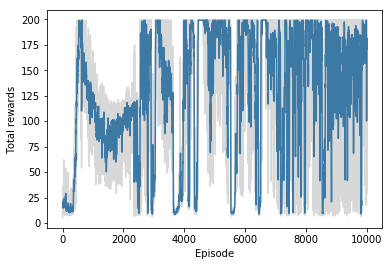

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

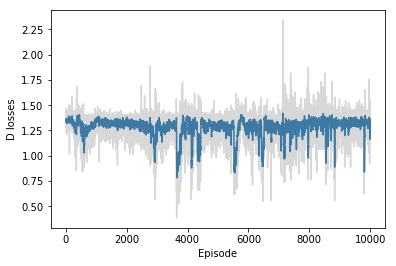

In [20]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

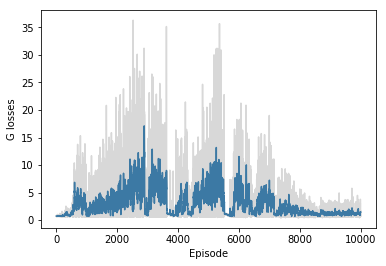

In [21]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

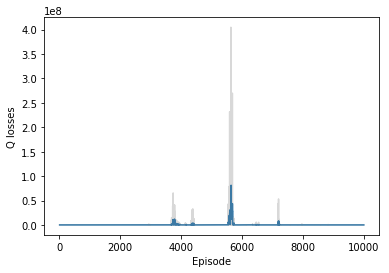

In [22]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [24]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.